In [ ]:
# Install data manipulation libraries
!pip install numpy pandas pandas_datareader

# Install visualization libraries
!pip install matplotlib seaborn plotly

# Install financial data libraries
!pip install yfinance yoptions

# Install scientific computing libraries
!pip install scipy scikit-learn statsmodels

In [2]:
# Data manipulation libraries
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Financial data libraries
import yfinance as yf

# Date and time libraries
from datetime import datetime

# Scientific computing libraries
from scipy.stats import linregress, skew, kurtosis
from scipy.optimize import minimize
from math import pi

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import yfinance as yf
from scipy.stats import kurtosis, skew

# Warnings
import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")

# Technical Features

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# from datetime import datetime, timedelta
# import yfinance as yf
# from scipy.stats import kurtosis, skew

class SPYDataAnalyzer:
    def __init__(self, years=10, cache_file='spy_data.csv'):
        self.years = years
        self.cache_file = cache_file
        self.data = None
    
    def fetch_data(self):
        # Check if data is cached and is up-to-date
        if os.path.exists(self.cache_file):
            modified_time = datetime.fromtimestamp(os.path.getmtime(self.cache_file))
            if datetime.now() - modified_time < timedelta(days=1):
                self.data = pd.read_csv(self.cache_file, parse_dates=['Date'], index_col='Date')
                return

        # Fetch data from Yahoo Finance
        end_date = datetime.now()
        start_date = end_date - timedelta(days=self.years * 365)
        spy = yf.download('SPY', start=start_date, end=end_date)
        self.data = spy[['Open', 'High', 'Low', 'Close']]
        self.data.to_csv(self.cache_file)
    
    def calculate_indicators(self):
        if self.data is None:
            raise ValueError("No data available. Please fetch data first.")
        
        # Calculate moving averages
        self.data['20_MA'] = self.data['Close'].rolling(window=20).mean()
        self.data['52_Week_MA'] = self.data['Close'].rolling(window=260).mean()
        
        # Calculate Bollinger Bands for 20-day and 52-week
        self.data['20_Upper_BB'] = self.data['20_MA'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['20_Lower_BB'] = self.data['20_MA'] - 2 * self.data['Close'].rolling(window=20).std()
        self.data['52_Upper_BB'] = self.data['52_Week_MA'] + 2 * self.data['Close'].rolling(window=260).std()
        self.data['52_Lower_BB'] = self.data['52_Week_MA'] - 2 * self.data['Close'].rolling(window=260).std()
        
        # Calculate daily returns and other statistics
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Cumulative_Return'] = (1 + self.data['Daily_Return']).cumprod() - 1
        self.data['Std_Dev'] = self.data['Daily_Return'].rolling(window=20).std()
        
        # Calculate statistical metrics only where there are enough data points
        self.data['Skewness'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: skew(x.dropna()), raw=False)
        self.data['Kurtosis'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: kurtosis(x.dropna()), raw=False)
        self.data['Positive_Return_Percentage'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: (x > 0).mean() * 100, raw=False)
        
        # Calculate Kelly ratio and fraction based on available returns
        win_rate = self.data['Positive_Return_Percentage'] / 100
        loss_rate = 1 - win_rate
        avg_win = self.data[self.data['Daily_Return'] > 0]['Daily_Return'].mean()
        avg_loss = abs(self.data[self.data['Daily_Return'] <= 0]['Daily_Return'].mean())
        self.data['Kelly_Ratio'] = win_rate - (loss_rate / (avg_win / avg_loss))
        self.data['Kelly_Fraction'] = self.data['Kelly_Ratio'] / 2
        
        # Drop initial rows with NaN values after calculations
        self.data.dropna(inplace=True)

    def get_data(self):
        return self.data
    
    def save_to_csv(self, filename='spy_analyzed_data.csv'):
        if self.data is not None:
            self.data.to_csv(filename)
        else:
            raise ValueError("No data available to save. Please fetch and process data first.")

# Example usage
analyzer = SPYDataAnalyzer(years=10)
analyzer.fetch_data()
analyzer.calculate_indicators()
data = analyzer.get_data()
print(data.head())
# data.to_csv('spy_analyzed_output.csv')


In [ ]:
# Define the list of tickers
tickers = ['SPY', 'SPI', 'UPRO', 'SPXS']

# Create a directory for raw data if it doesn't exist
import os

output_dir = 'raw_data'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each ticker and save the data to CSV
for ticker in tickers:
    data.to_csv(f'{output_dir}/{ticker}_analyzed_output.csv')

# Define the list of tickers related to QQQ
qqq_related_tickers = ['QQQ', 'PSQ', 'SQQQ', 'TQQQ']

# Iterate through each ticker and save the data to CSV
for ticker in qqq_related_tickers:
    data.to_csv(f'{output_dir}/{ticker}_analyzed_output.csv')


In [ ]:
# Class for Comprehensive Financial Data Visualization
class FinancialDataVisualizer:
    """
    Overview:
    This class is designed to visualize various financial metrics from a dataset. It provides a comprehensive overview of a stock's performance by plotting key indicators such as daily return, cumulative return, volatility, skewness, kurtosis, and Kelly ratio. The plots are arranged in a 3x3 grid for easy comparison and analysis.

    Attributes:
    - data (pd.DataFrame): The dataset containing financial metrics.
    - asset_name (str): The name of the asset being analyzed.

    Methods:
    - plot(): Generates a 3x3 grid of plots for various financial metrics.
    """
    def __init__(self, data, asset_name):
        self.data = data
        self.asset_name = asset_name

    def plot(self):
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f'Financial Data Visualization for {self.asset_name}', fontsize=16)

        axs[0, 0].plot(self.data.index, self.data['Daily_Return'], color='orange')
        axs[0, 0].set_title('Daily Return')
        axs[0, 0].set_xlabel('Date')
        axs[0, 0].set_ylabel('Return')

        axs[0, 1].plot(self.data.index, self.data['Cumulative_Return'], color='purple')
        axs[0, 1].set_title('Cumulative Return')
        axs[0, 1].set_xlabel('Date')
        axs[0, 1].set_ylabel('Cumulative Return')

        axs[0, 2].plot(self.data.index, self.data['Std_Dev'], color='blue')
        axs[0, 2].set_title('Rolling Standard Deviation (Volatility)')
        axs[0, 2].set_xlabel('Date')
        axs[0, 2].set_ylabel('Standard Deviation')

        axs[1, 0].plot(self.data.index, self.data['Skewness'], color='green')
        axs[1, 0].set_title('Rolling Skewness')
        axs[1, 0].set_xlabel('Date')
        axs[1, 0].set_ylabel('Skewness')

        axs[1, 1].plot(self.data.index, self.data['Kurtosis'], color='red')
        axs[1, 1].set_title('Rolling Kurtosis')
        axs[1, 1].set_xlabel('Date')
        axs[1, 1].set_ylabel('Kurtosis')

        axs[1, 2].plot(self.data.index, self.data['Positive_Return_Percentage'], color='cyan')
        axs[1, 2].set_title('Positive Return Percentage (20-Day)')
        axs[1, 2].set_xlabel('Date')
        axs[1, 2].set_ylabel('Percentage')

        axs[2, 0].plot(self.data.index, self.data['Kelly_Ratio'], color='magenta')
        axs[2, 0].set_title('Kelly Ratio')
        axs[2, 0].set_xlabel('Date')
        axs[2, 0].set_ylabel('Kelly Ratio')

        axs[2, 1].plot(self.data.index, self.data['Kelly_Fraction'], color='brown')
        axs[2, 1].set_title('Kelly Fraction')
        axs[2, 1].set_xlabel('Date')
        axs[2, 1].set_ylabel('Kelly Fraction')

        plt.tight_layout()
        plt.show()

# Load the data from the uploaded CSV file
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create an instance of the visualizer class and plot all visualizations side by side
data_viz = FinancialDataVisualizer(data, 'SPY')
data_viz.plot()


# Thoughts
How would a quant interpret the data, to determine whether to buy share, or trade these options to hedge. For example, the Kelly fraction could be used to determine the % of a portfolio to DCA into individual shares or fractional shares. Low volatility and low probability of positive returns could mean a bearish call spread relative to % return, and high volatility and very low positive returns could be a bearish call ladder opportunity. I also could be entirely wrong about those examples, you tell me.

1. Kelly Fraction
Interpretation: The Kelly Fraction is a measure of how much of a portfolio should be allocated to an investment to maximize growth over the long term, balancing risk and reward. A higher Kelly Fraction suggests higher confidence in positive returns.
Usage:
High Kelly Fraction: Indicates favorable market conditions. This could signal that it’s a good time to buy shares or to enter a bull put spread as a way to generate income, expecting prices to stay above a certain level.
Low or Negative Kelly Fraction: Suggests caution, as the expected returns do not justify the risk. In such cases, a bear call spread might be appropriate to profit from expected declines or stagnation without risking too much capital.

2. Volatility (Standard Deviation)
Interpretation: High volatility means large price swings, which can offer more opportunities for options traders but also comes with higher risk. Low volatility suggests a stable market, which may favor more conservative strategies.
Usage:
High Volatility: Ideal for strategies that benefit from large price movements, like bear call ladders or bull put ladders. These strategies can profit from significant movement in either direction and are more suitable when large price swings are expected.
Low Volatility: Indicates stability, which might be better for strategies like bull put spreads where limited movement is expected. Here, you are betting that the price will not drop significantly below a certain level.

3. Positive Return Percentage
Interpretation: A high positive return percentage suggests that the stock has been frequently increasing in value, signaling bullish sentiment. A low percentage indicates bearish sentiment or market corrections.
Usage:
High Positive Return Percentage: A favorable outlook for buying shares or using a bull put spread. The expectation is that the price will remain stable or rise, allowing the puts sold at a higher strike to expire worthless, yielding profit.
Low Positive Return Percentage: May indicate a bearish outlook. Strategies like a bear call spread could be used to capitalize on the likelihood of the stock not surpassing a certain price level.

4. Skewness
Interpretation: Measures the asymmetry of return distribution. Positive skewness means more small losses and occasional large gains, while negative skewness implies more small gains with rare large losses.
Usage:
Positive Skewness: Suggests potential for occasional large gains. This could align with strategies like bull put ladders where you benefit from large upward movements while having limited downside risk.
Negative Skewness: Indicates frequent small gains but vulnerability to large drops. A bear call spread or bear call ladder might be suitable to protect against significant declines.

5. Kurtosis
Interpretation: High kurtosis indicates a lot of outliers—extreme returns, both positive and negative. Low kurtosis suggests returns are closer to a normal distribution.
Usage:
High Kurtosis: High risk of large moves. Strategies like ladders (bear call or bull put) are appropriate as they can capitalize on large price movements while capping potential losses.
Low Kurtosis: Less risk of extreme moves. More stable environments where simple spread strategies might be preferable, such as a bull put spread for a bullish outlook or a bear call spread for a bearish outlook.

Example Application:

Scenario 1: If the Kelly Fraction is high, volatility is low, and the positive return percentage is high, a quant might prefer dollar-cost averaging (DCA) into shares, as this indicates a strong, stable bullish trend. Alternatively, a bull put spread could be used to generate income while maintaining limited risk.

Scenario 2: If volatility is high, Kelly Fraction is low, and skewness is negative (suggesting risk of large downward moves), a bear call ladder might be used. This strategy could profit from large downward movements while limiting potential losses.

Scenario 3: If skewness and kurtosis are both high, indicating frequent small gains but risk of large losses, a bear call spread could be a good defensive strategy, protecting against sharp declines while allowing some profit if the price remains below a certain level.

In [ ]:
# Analyze the existing data for monthly performance
import pandas as pd

# Load the data from the CSV file (assuming it has been uploaded previously)
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create a new column for the month to categorize data
data['Month'] = data.index.month

# Function to categorize months
def categorize_month(month):
    if month in [8, 9]:  # August, September
        return 'Bearish'
    elif month in [1, 4, 11, 12]:  # January, April, November, December
        return 'Bullish'
    else:
        return 'Neutral'

# Apply the categorization function
data['Month_Category'] = data['Month'].apply(categorize_month)

# Calculate average metrics for each month category
monthly_stats = data.groupby('Month_Category').agg({
    'Kelly_Ratio': 'mean',
    'Kelly_Fraction': 'mean',
    'Std_Dev': 'mean',
    'Positive_Return_Percentage': 'mean',
    'Skewness': 'mean',
    'Kurtosis': 'mean'
})

monthly_stats



Strategy: The combination of lower Kelly Ratio, lower positive return percentage, negative skewness, and positive kurtosis suggests that bearish strategies are appropriate. A Bear Call Spread would be ideal to capitalize on limited upside while protecting against potential declines. For higher volatility within these months, a Bear Call Ladder could be considered, especially if kurtosis and skewness values indicate the potential for large price swings.

Bullish Months (January, April, November, December):

Kelly Ratio: 0.0757, Kelly Fraction: 0.0378 – Higher, suggesting more confidence in positive returns.
Volatility (Std_Dev): 0.0095 – Moderate volatility, indicating some movement but within a bullish trend.
Positive Return Percentage: 54.69% – Higher, consistent with bullish sentiment.
Skewness: 0.1009 – Positive skewness implies more frequent small losses and fewer large gains.
Kurtosis: -0.0447 – Negative kurtosis suggests less likelihood of extreme movements.
Strategy: Higher Kelly ratios, positive return percentage, and moderate volatility suggest bullish strategies. A Bull Put Spread is appropriate, benefiting from a stable or rising market. If there are expectations of larger upward movements (based on specific market events or economic data), a Bull Put Ladder can capture larger gains with controlled risk.

Neutral or Mixed Months (Remaining Months):

Kelly Ratio: 0.0751, Kelly Fraction: 0.0375 – Similar to bullish months but requires more careful monitoring.
Volatility (Std_Dev): 0.0099 – Highest among categories, indicating unpredictability.
Positive Return Percentage: 54.66% – Comparable to bullish months, suggesting mixed sentiment.
Skewness: -0.1997 – Slightly negative, indicating a tendency towards losses.
Kurtosis: 0.0694 – Slightly positive, indicating some risk of extreme movements.
Strategy: In neutral or mixed months, where volatility is highest and sentiment is unclear, non-directional strategies such as an Iron Condor are appropriate. These strategies profit from limited price movement and can be adjusted if the market starts to trend.

Conclusion
By applying quantitative metrics to historical data, we can align option trading strategies with expected market conditions:

Bearish Months: Favor bear call spreads or ladders, expecting limited upside.
Bullish Months: Favor bull put spreads or ladders, expecting price stability or rise.
Neutral Months: Favor non-directional strategies like iron condors, expecting limited movement.


# Macro & Fundemental 

In [ ]:
class FinancialMacroDataProcessor:
    def __init__(self, ticker, macro_series, start_date='2008-01-01', end_date=None, plot=True):
        self.ticker = ticker
        self.macro_series = macro_series
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        self.plot = plot

    def fetch_financial_data(self):
        return yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def fetch_macro_data(self):
        return pdr.get_data_fred(self.macro_series, start=self.start_date).resample('M').ffill()

    def calculate_technical_indicators(self, financial_df):
        financial_df['20 Day MA'] = financial_df['Close'].rolling(window=20).mean()
        financial_df['20 Day STD'] = financial_df['Close'].rolling(window=20).std()
        financial_df['Upper Band'] = financial_df['20 Day MA'] + 2 * financial_df['20 Day STD']
        financial_df['Lower Band'] = financial_df['20 Day MA'] - 2 * financial_df['20 Day STD']
        
        delta = financial_df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        financial_df['RSI'] = 100 - (100 / (1 + gain / loss))
        
        financial_df['MACD'] = financial_df['Close'].ewm(span=12, adjust=False).mean() - financial_df['Close'].ewm(span=26, adjust=False).mean()
        financial_df['Signal Line'] = financial_df['MACD'].ewm(span=9, adjust=False).mean()
        return financial_df

    def merge_data(self, financial_df, macro_df):
        return financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')

    def plot_data(self, merged_df):
        fig, axs = plt.subplots(5, 1, figsize=(14, 20))

        # Plot Close Price and Bollinger Bands
        axs[0].plot(merged_df['Close'], label='Close Price')
        axs[0].plot(merged_df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
        axs[0].plot(merged_df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
        axs[0].fill_between(merged_df.index, merged_df['Upper Band'], merged_df['Lower Band'], alpha=0.1)
        axs[0].set_title('Monthly Close Price and Bollinger Bands')
        axs[0].legend()

        # Plot RSI
        axs[1].plot(merged_df['RSI'], label='RSI', color='purple')
        axs[1].axhline(70, linestyle='--', alpha=0.5, color='r')
        axs[1].axhline(30, linestyle='--', alpha=0.5, color='g')
        axs[1].set_title('Monthly Relative Strength Index (RSI)')
        axs[1].legend()

        # Plot MACD
        axs[2].plot(merged_df['MACD'], label='MACD', color='g')
        axs[2].plot(merged_df['Signal Line'], label='Signal Line', color='orange')
        axs[2].fill_between(merged_df.index, merged_df['MACD'] - merged_df['Signal Line'], 0, alpha=0.2, color='grey')
        axs[2].set_title('Monthly MACD and Signal Line')
        axs[2].legend()

        # Plot Fed Funds Rate
        axs[3].plot(merged_df[self.macro_series], label='Federal Funds Rate', color='blue')
        axs[3].set_title('Federal Funds Rate')
        axs[3].legend()

        # Plot Monthly Seasonality
        monthly_returns = merged_df['Close'].pct_change().groupby(merged_df.index.month).mean()
        axs[4].bar(monthly_returns.index, monthly_returns.values)
        axs[4].set_title('Average Monthly Returns')
        axs[4].set_xlabel('Month')
        axs[4].set_ylabel('Average Return')
        axs[4].set_xticks(range(1, 13))
        axs[4].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

        plt.tight_layout()
        plt.show()

        # Plot 52-week seasonality
        weekly_returns = merged_df['Close'].pct_change().groupby(merged_df.index.isocalendar().week).mean()
        plt.figure(figsize=(14, 6))
        plt.plot(weekly_returns.index, weekly_returns.values)
        plt.title('Average 52-Week Returns')
        plt.xlabel('Week of the Year')
        plt.ylabel('Average Return')
        plt.xticks(range(1, 53, 4))
        plt.grid(True)
        plt.show()

    def process(self):
        financial_df = self.fetch_financial_data()
        macro_df = self.fetch_macro_data()
        financial_df = self.calculate_technical_indicators(financial_df)
        merged_df = self.merge_data(financial_df, macro_df)
        # print("Merged Data:\n", merged_df.head())
        if self.plot:
            self.plot_data(merged_df)
        return merged_df

# Example usage:

# Fetch, merge, and plot financial data with Fed Funds Rate
processor = FinancialMacroDataProcessor(ticker='SPY', macro_series='FEDFUNDS', start_date='2010-01-01', plot=True)
merged_data = processor.process()
merged_data

# Display Monthly Seasonality

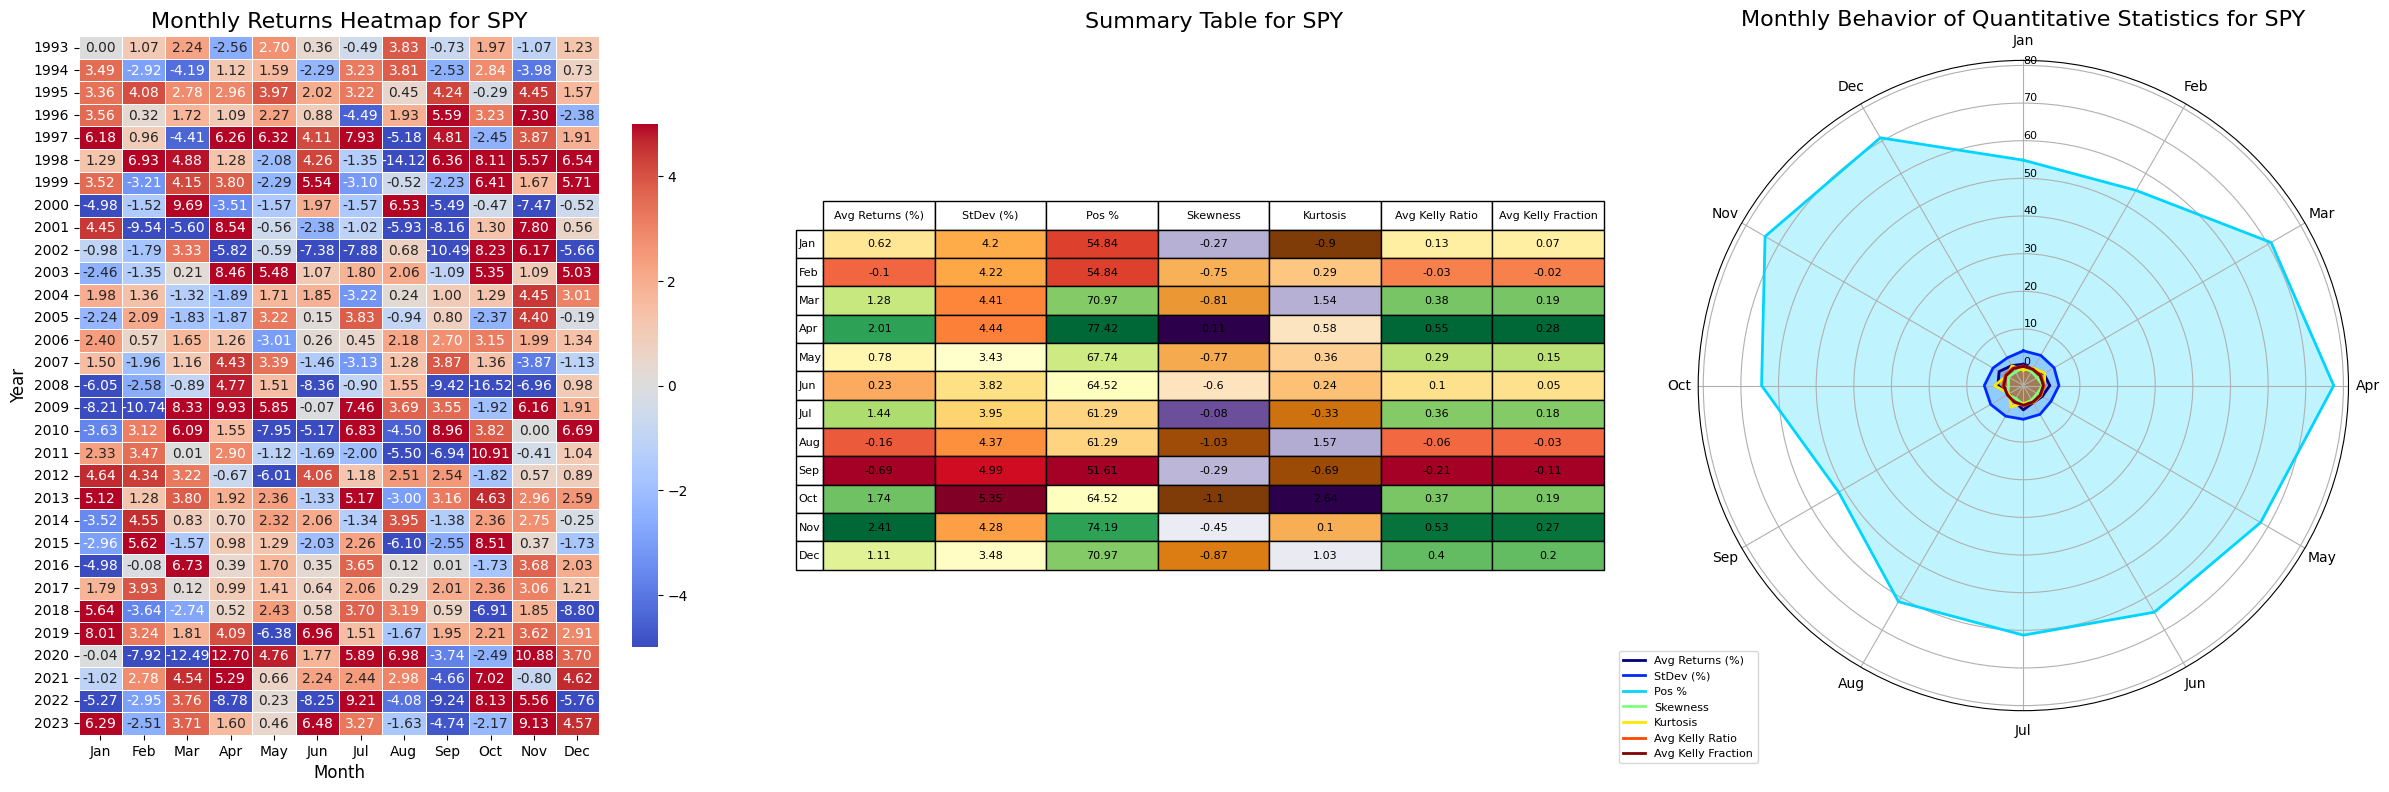

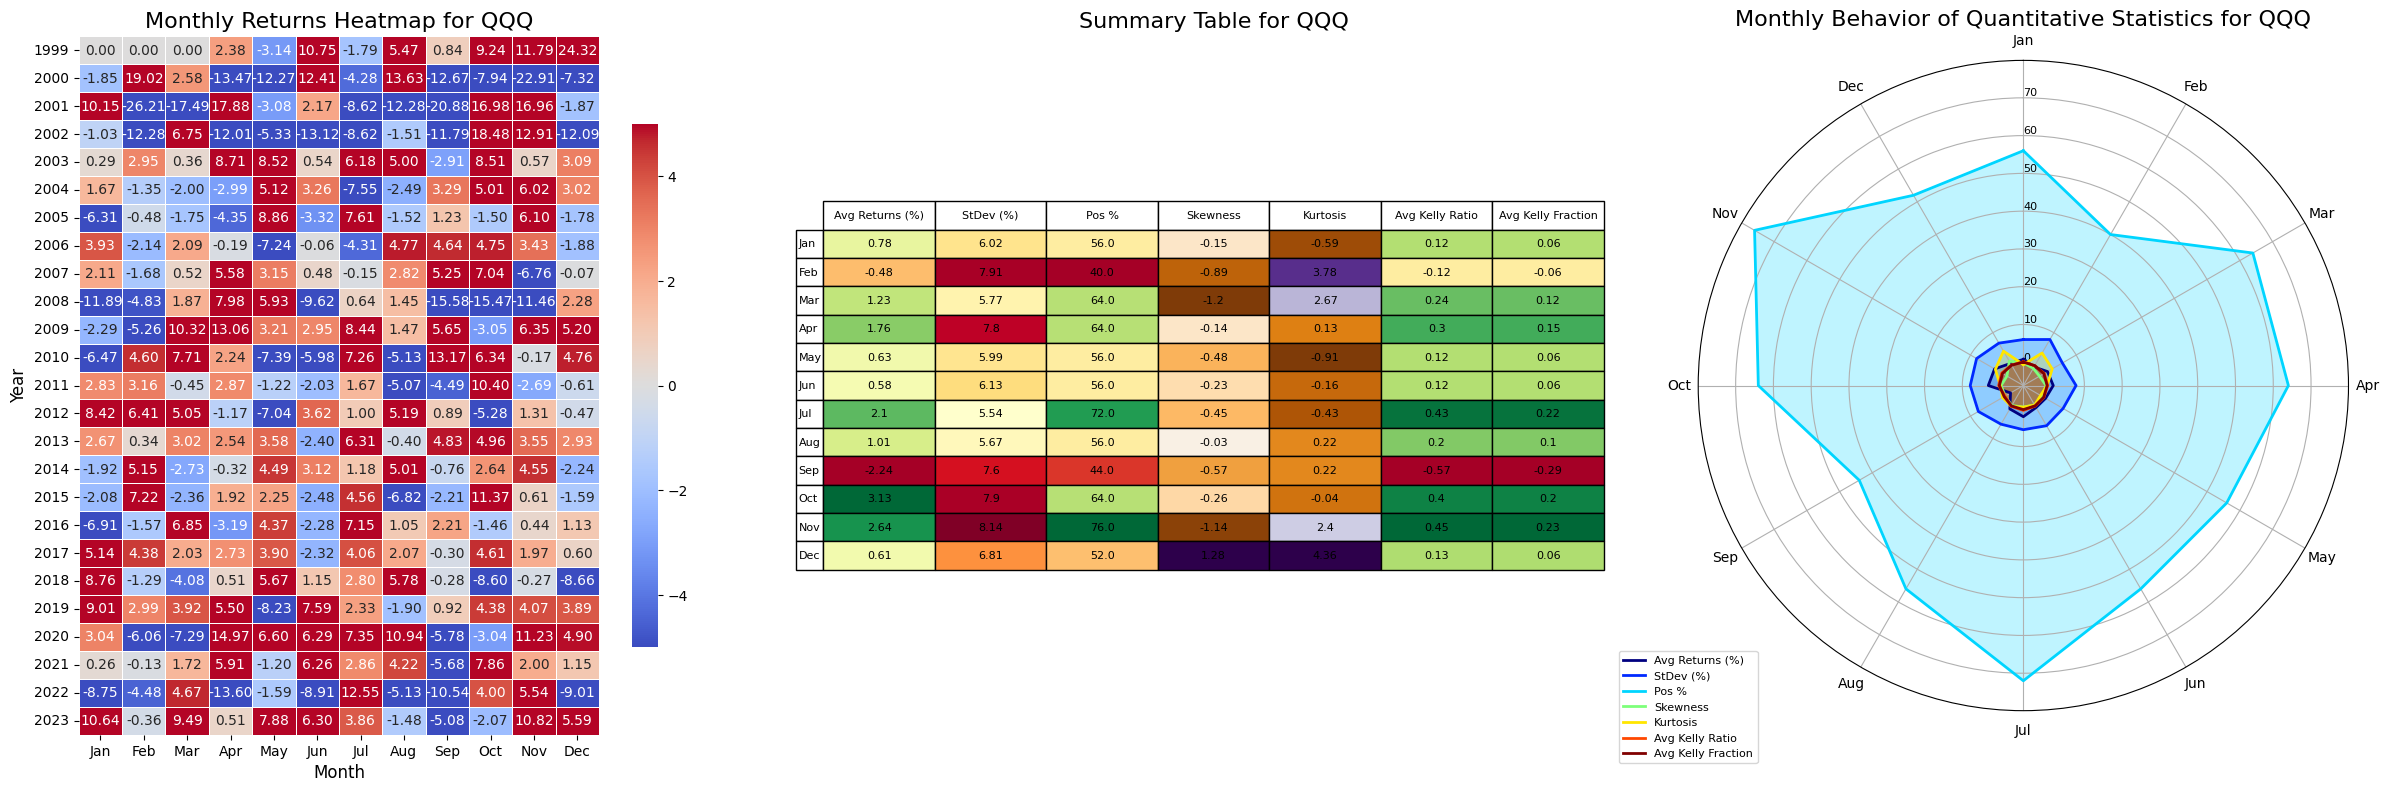

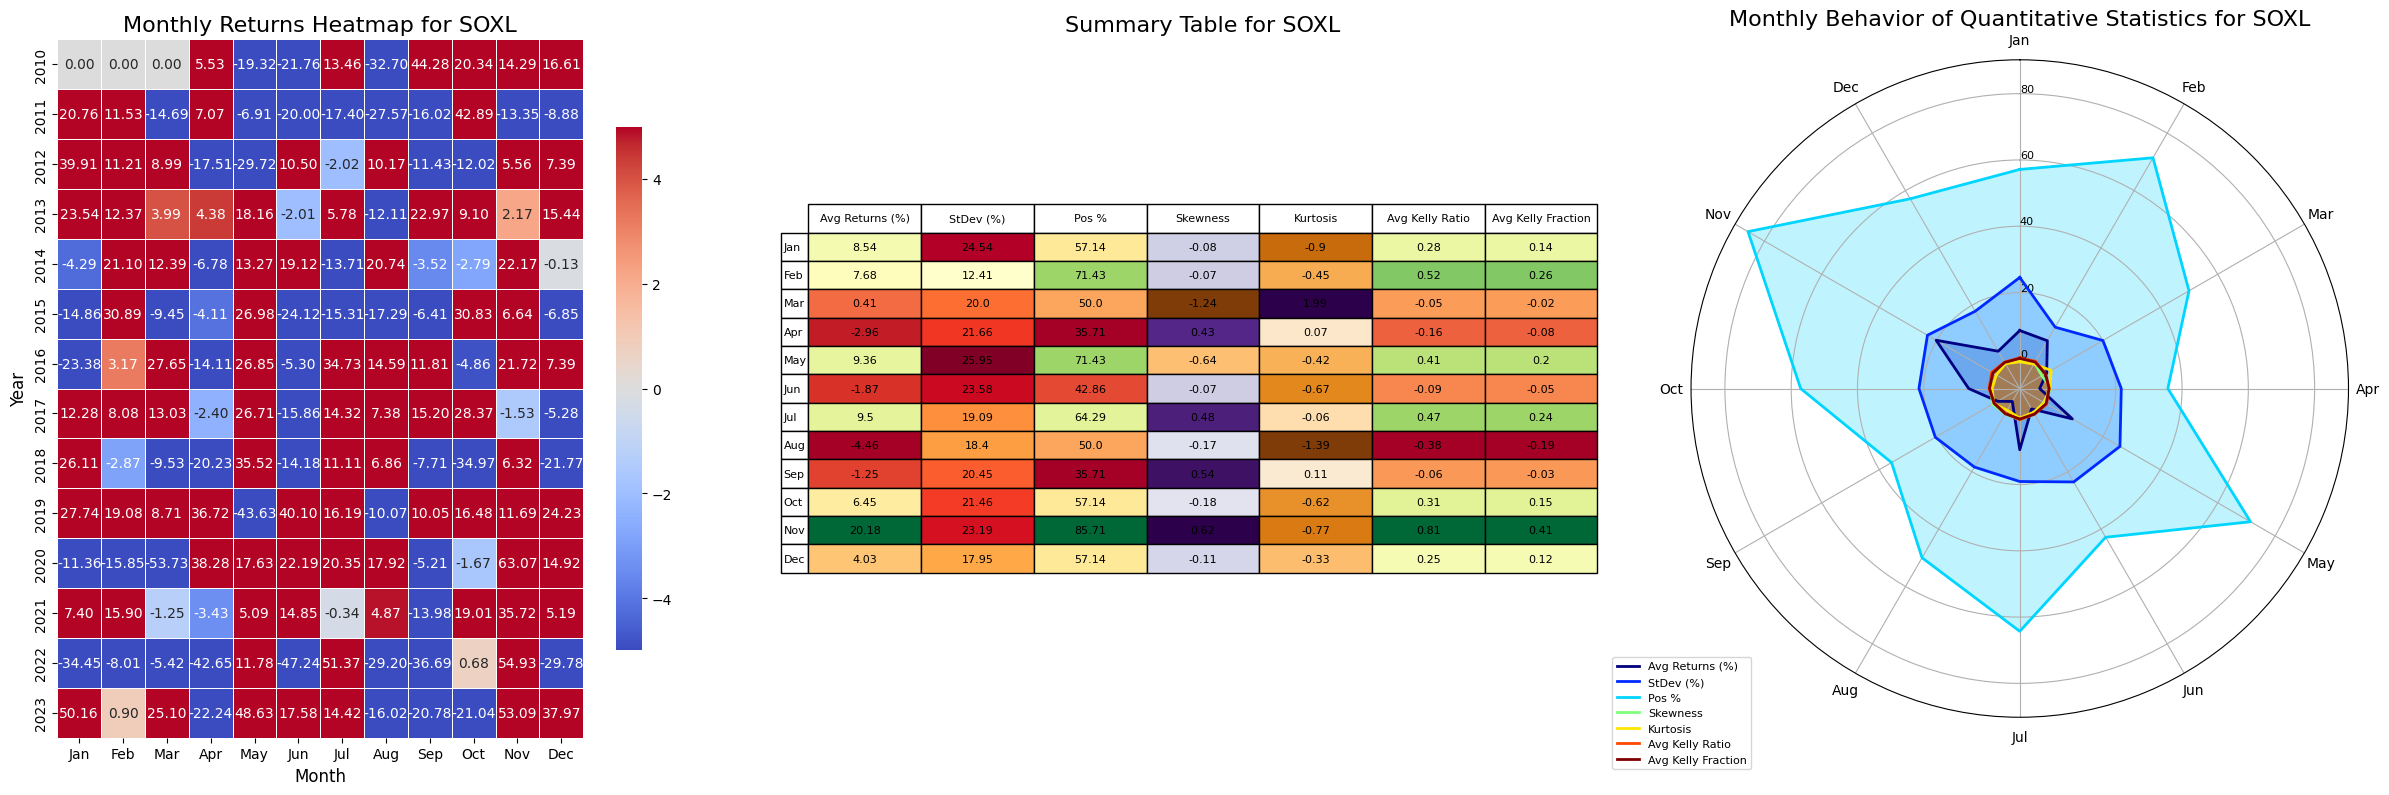

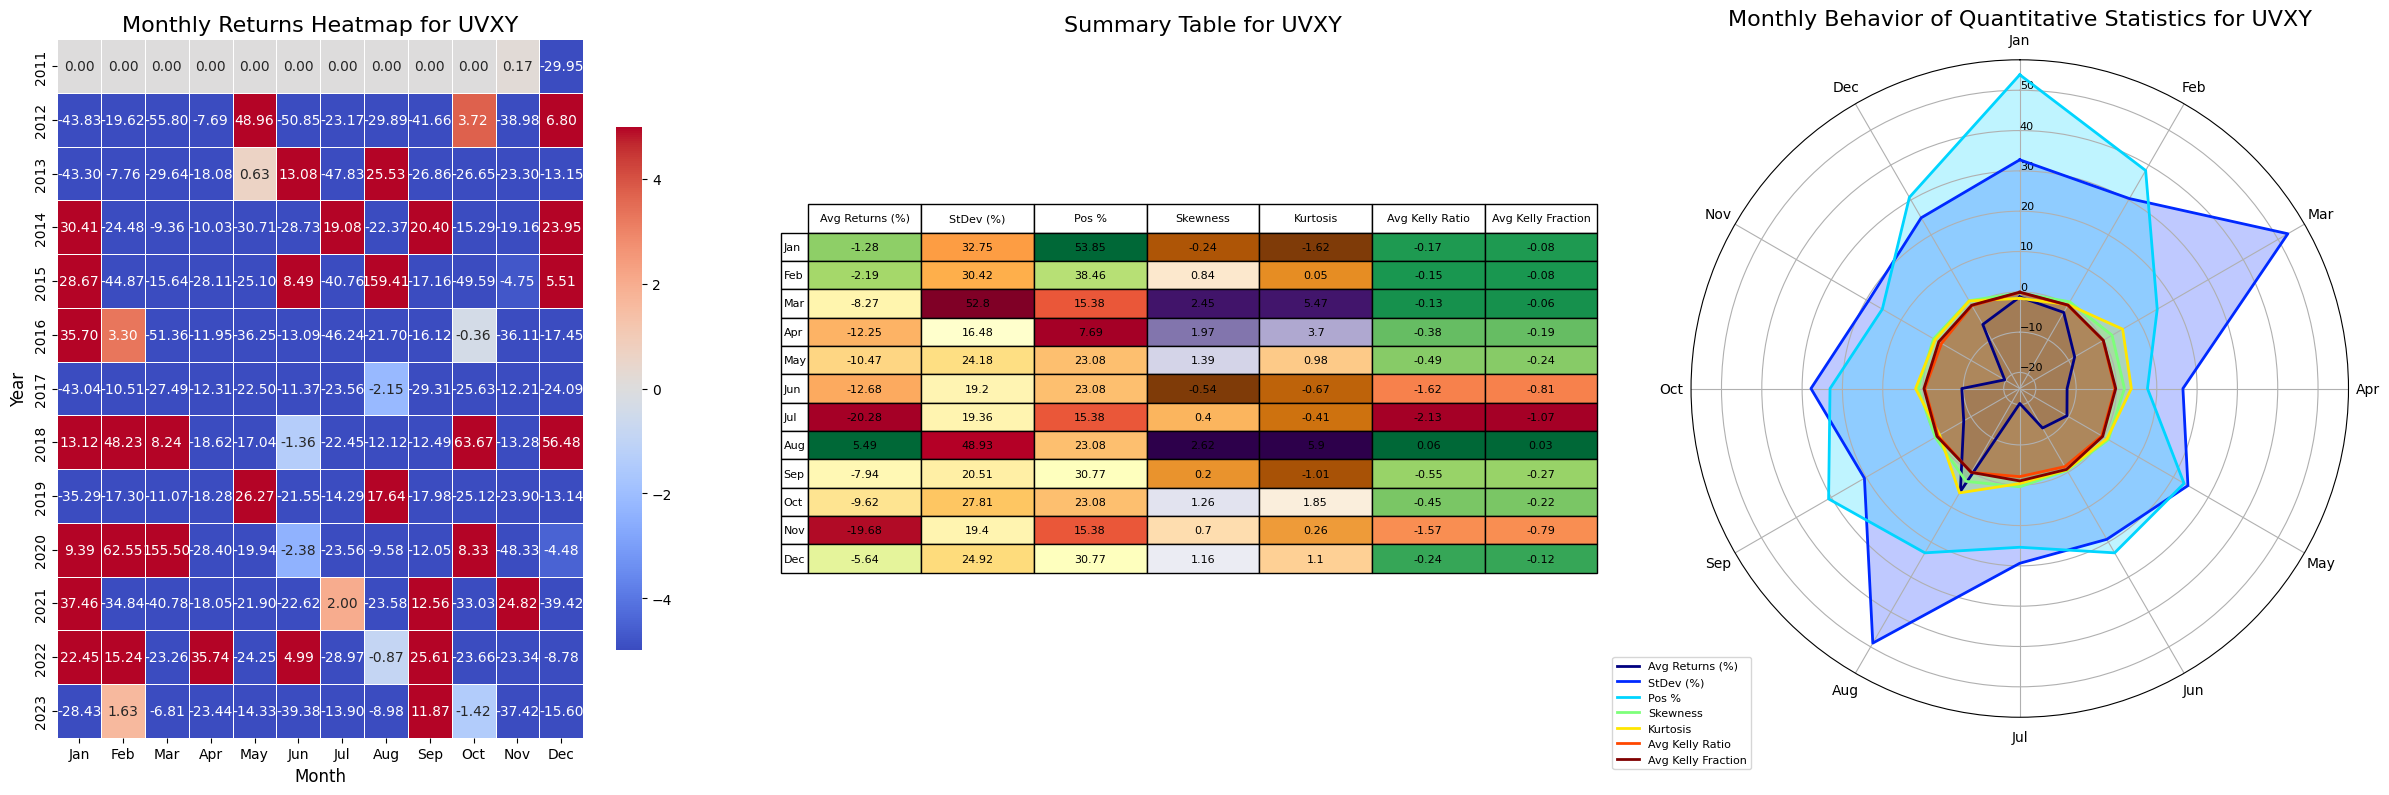

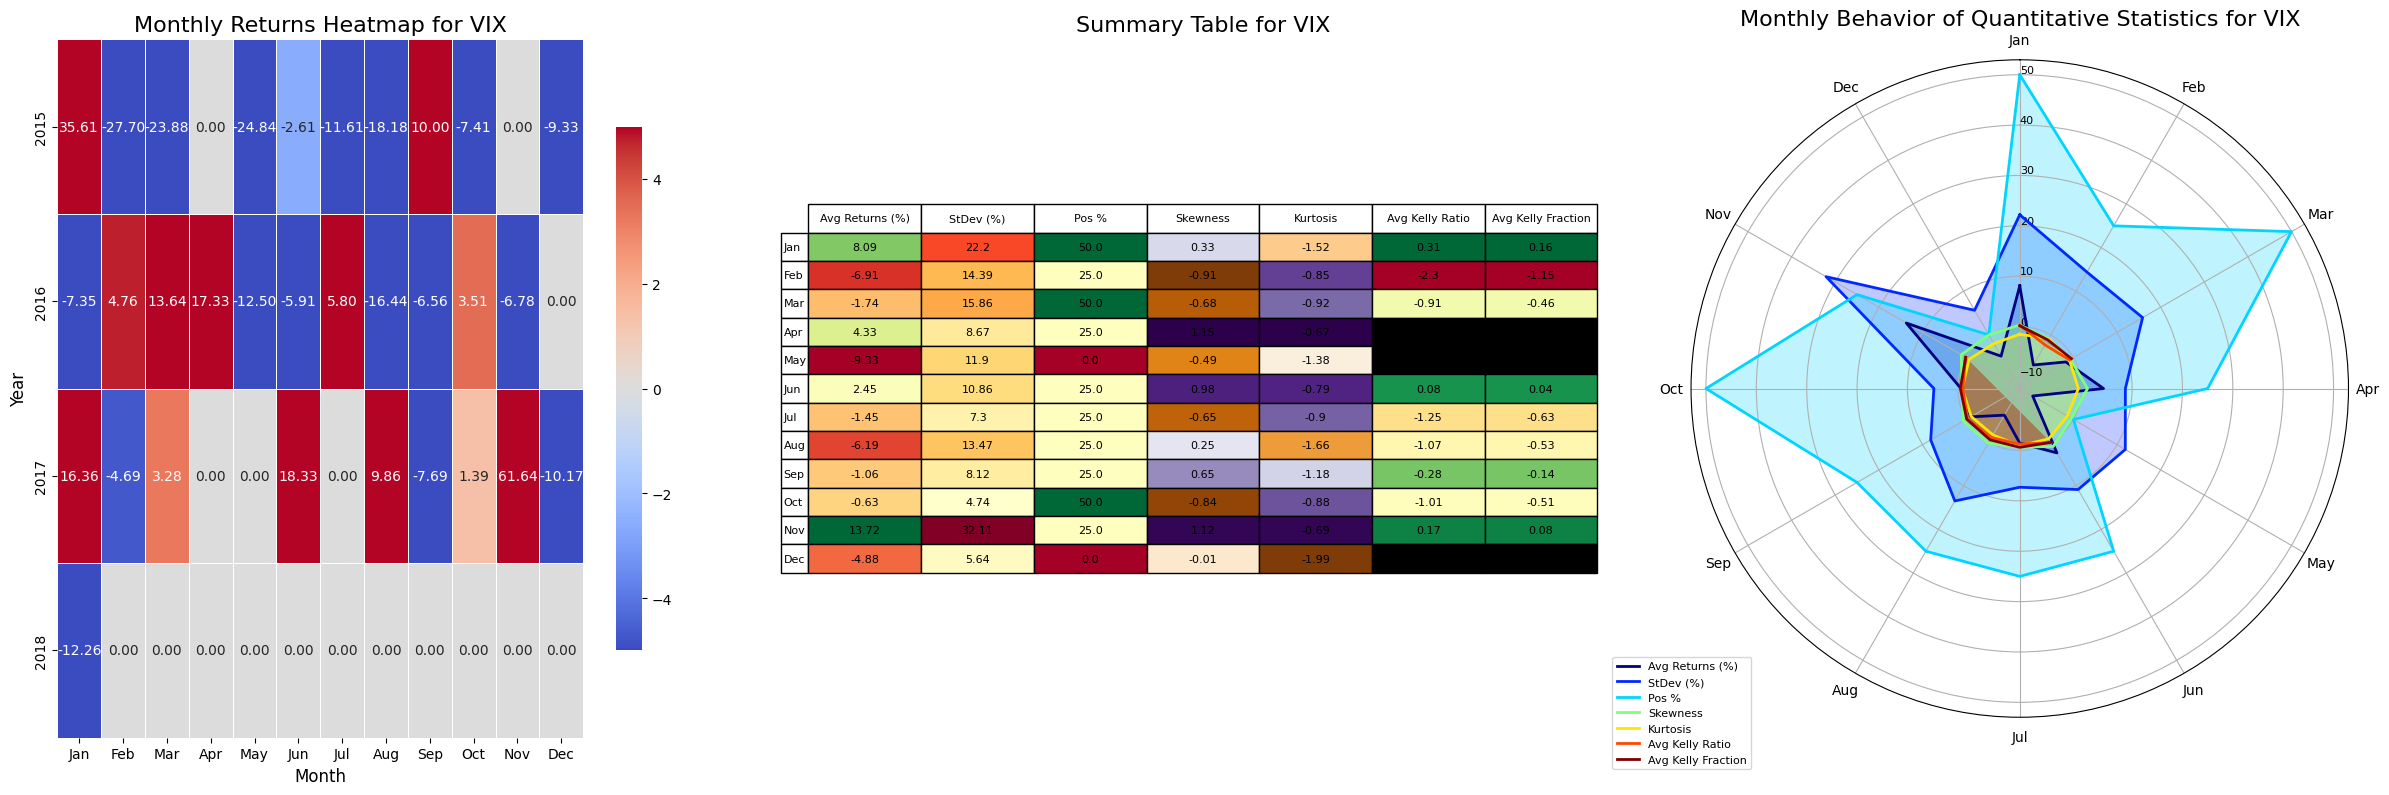

In [6]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import skew, kurtosis
# from math import pi

class MonthlySeasonalityAnalyzer:
    def __init__(self, ticker='SPY', start='1990-01-01', end='2023-12-31'):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.data = None
        self.pivot_table = None
        self.summary_table = None

    def fetch_and_process_data(self):
        # Fetch data
        self.data = yf.download(self.ticker, start=self.start, end=self.end, progress=False)['Adj Close']
        
        # Calculate monthly returns
        monthly_data = self.data.resample('M').ffill()
        monthly_returns = monthly_data.pct_change().dropna() * 100  # Convert to percentage
        
        # Organize returns into a pivot table
        monthly_returns = monthly_returns.to_frame(name='Adj Close')
        monthly_returns['Year'] = monthly_returns.index.to_period('M').year
        monthly_returns['Month'] = monthly_returns.index.to_period('M').month
        monthly_returns['Month'] = monthly_returns['Month'].apply(lambda x: pd.Timestamp(2023, x, 1).strftime('%b'))  # Using strftime to get month abbreviation
        self.pivot_table = monthly_returns.pivot_table(index='Year', columns='Month', values='Adj Close', aggfunc='mean')
        self.pivot_table = self.pivot_table.fillna(0)  # Replace NaN with 0 for months without data

    def calculate_metrics(self):
        # Ensure columns are in the correct order
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        self.pivot_table = self.pivot_table[months]

        # Function to calculate Kelly ratio and fraction
        def calculate_kelly_ratio(returns):
            win_prob = np.mean(returns > 0)
            loss_prob = 1 - win_prob
            win_return = np.mean(returns[returns > 0])
            loss_return = abs(np.mean(returns[returns < 0]))
            kelly_ratio = win_prob - (loss_prob / (win_return / loss_return))
            return kelly_ratio, kelly_ratio / 2  # Kelly fraction as half of Kelly ratio

        # Calculate metrics
        avg_returns = self.pivot_table.mean()
        std_dev = self.pivot_table.std()
        pos_perc = (self.pivot_table > 0).mean() * 100
        skewness = self.pivot_table.apply(lambda x: skew(x.dropna()), axis=0)
        kurt = self.pivot_table.apply(lambda x: kurtosis(x.dropna()), axis=0)

        # Kelly ratio and fraction
        kelly_ratios = self.pivot_table.apply(lambda x: calculate_kelly_ratio(x.dropna()), axis=0)
        avg_kelly_ratio = kelly_ratios.apply(lambda x: x[0])
        avg_kelly_fraction = kelly_ratios.apply(lambda x: x[1])

        # Create summary table
        self.summary_table = pd.DataFrame({
            'Avg Returns (%)': avg_returns,
            'StDev (%)': std_dev,
            'Pos %': pos_perc,
            'Skewness': skewness,
            'Kurtosis': kurt,
            'Avg Kelly Ratio': avg_kelly_ratio,
            'Avg Kelly Fraction': avg_kelly_fraction
        })

    def visualize_data(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        
        # Heatmap
        sns.heatmap(self.pivot_table, annot=True, fmt=".2f", cmap="coolwarm", vmin=-5, vmax=5, center=0, linewidths=.5, cbar_kws={"shrink": .75}, ax=ax1)
        ax1.set_title(f'Monthly Returns Heatmap for {self.ticker}', fontsize=16)
        ax1.set_xlabel('Month', fontsize=12)
        ax1.set_ylabel('Year', fontsize=12)
        ax1.tick_params(axis='both', which='major', labelsize=10)

        # Summary table
        ax2.axis('tight')
        ax2.axis('off')
        
        def color_scale(val, cmap, vmin, vmax):
            norm = plt.Normalize(vmin, vmax)
            return plt.cm.colors.rgb2hex(cmap(norm(val)))
        
        cell_colors = []
        for col in self.summary_table.columns:
            if col in ['Avg Returns (%)', 'Pos %', 'Avg Kelly Ratio', 'Avg Kelly Fraction']:
                colors = [color_scale(x, plt.cm.RdYlGn, self.summary_table[col].min(), self.summary_table[col].max()) for x in self.summary_table[col]]
            elif col == 'StDev (%)':
                colors = [color_scale(x, plt.cm.YlOrRd, self.summary_table[col].min(), self.summary_table[col].max()) for x in self.summary_table[col]]
            else:  # Skewness and Kurtosis
                colors = [color_scale(x, plt.cm.PuOr, self.summary_table[col].min(), self.summary_table[col].max()) for x in self.summary_table[col]]
            cell_colors.append(colors)
        
        table = ax2.table(cellText=self.summary_table.values.round(2), 
                         colLabels=self.summary_table.columns, 
                         rowLabels=self.summary_table.index, 
                         cellLoc='center', 
                         loc='center',
                         cellColours=list(map(list, zip(*cell_colors))))
        
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 1.5)
        
        ax2.set_title(f'Summary Table for {self.ticker}', fontsize=16)

        # Radar chart
        categories = list(self.summary_table.index)
        N = len(categories)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        if ax3:
            ax3.remove()
        ax3 = plt.subplot(133, polar=True)

        colors = plt.cm.jet(np.linspace(0, 1, 7))
        metrics = ['Avg Returns (%)', 'StDev (%)', 'Pos %', 'Skewness', 'Kurtosis', 'Avg Kelly Ratio', 'Avg Kelly Fraction']
        for i, column in enumerate(metrics):
            values = self.summary_table[column].values.flatten().tolist()
            values += values[:1]
            ax3.plot(angles, values, linewidth=2, linestyle='solid', label=column, color=colors[i])
            ax3.fill(angles, values, alpha=0.25, color=colors[i])

        ax3.set_theta_offset(pi / 2)
        ax3.set_theta_direction(-1)
        plt.xticks(angles[:-1], categories, fontsize=10)
        ax3.set_rlabel_position(0)
        plt.yticks(fontsize=8)
        ax3.set_title(f'Monthly Behavior of Quantitative Statistics for {self.ticker}', fontsize=16)
        ax3.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=8)

        plt.tight_layout()
        plt.show()

# Example usage:
tickers = ['SPY', 'QQQ', 'SOXL', 'UVXY', 'VIX']
for ticker in tickers:
    analyzer = MonthlySeasonalityAnalyzer(ticker=ticker)
    analyzer.fetch_and_process_data()
    analyzer.calculate_metrics()
    analyzer.visualize_data()


# 52 Week Seasonality with Kelly Method

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


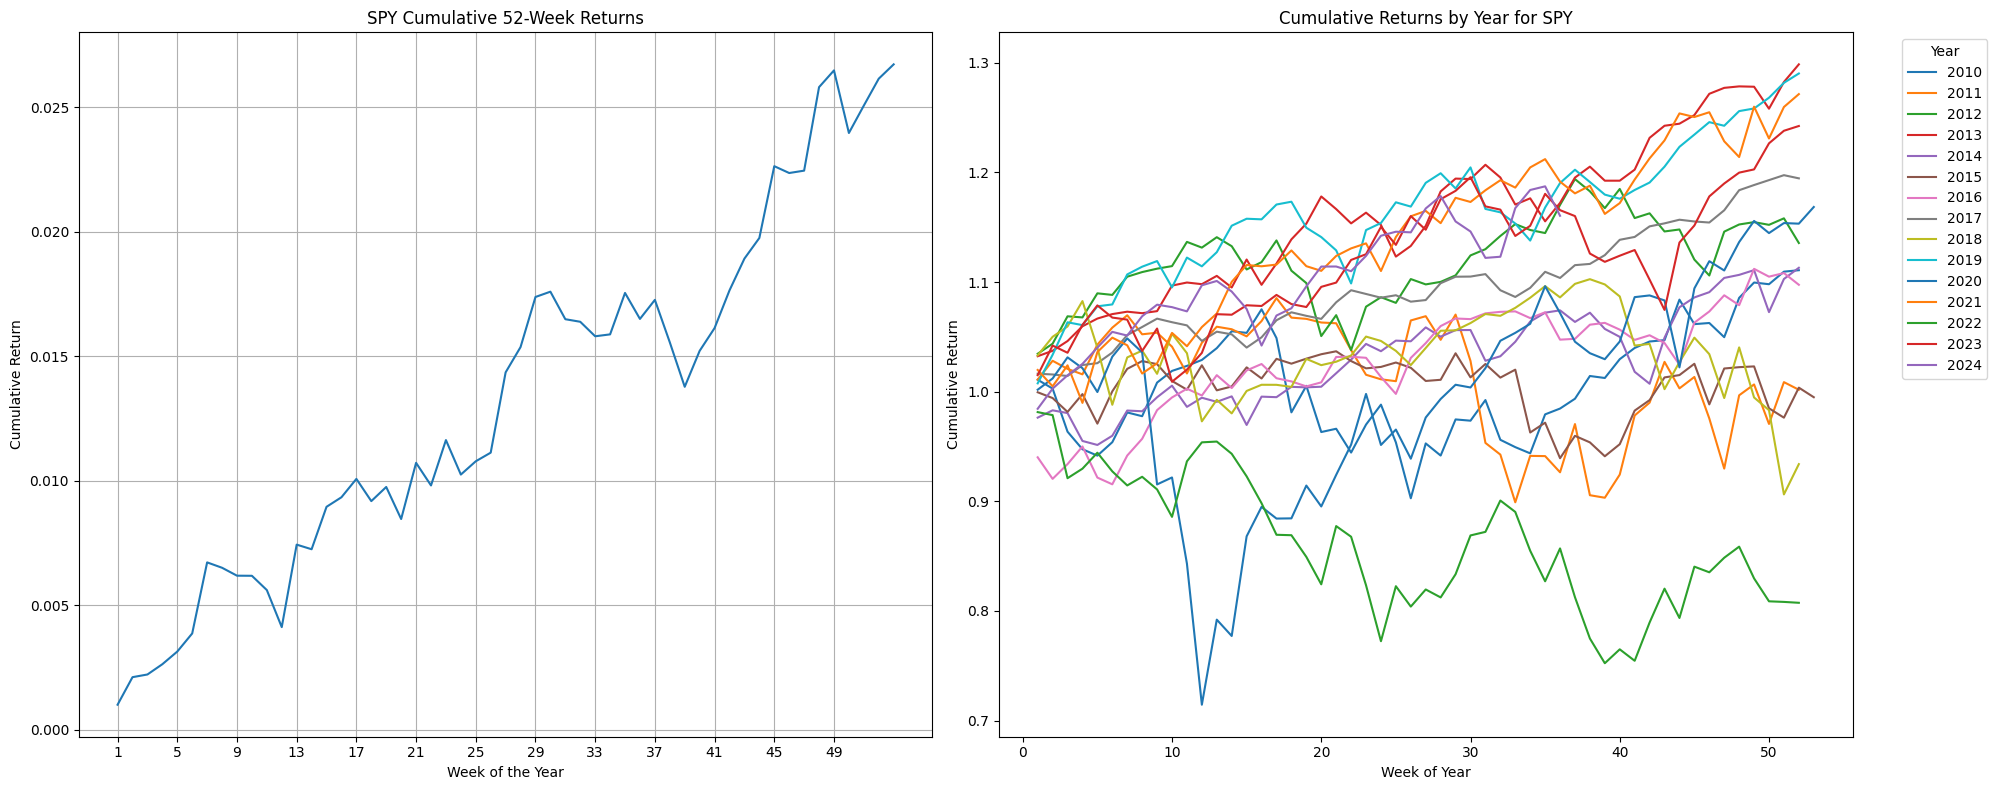

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


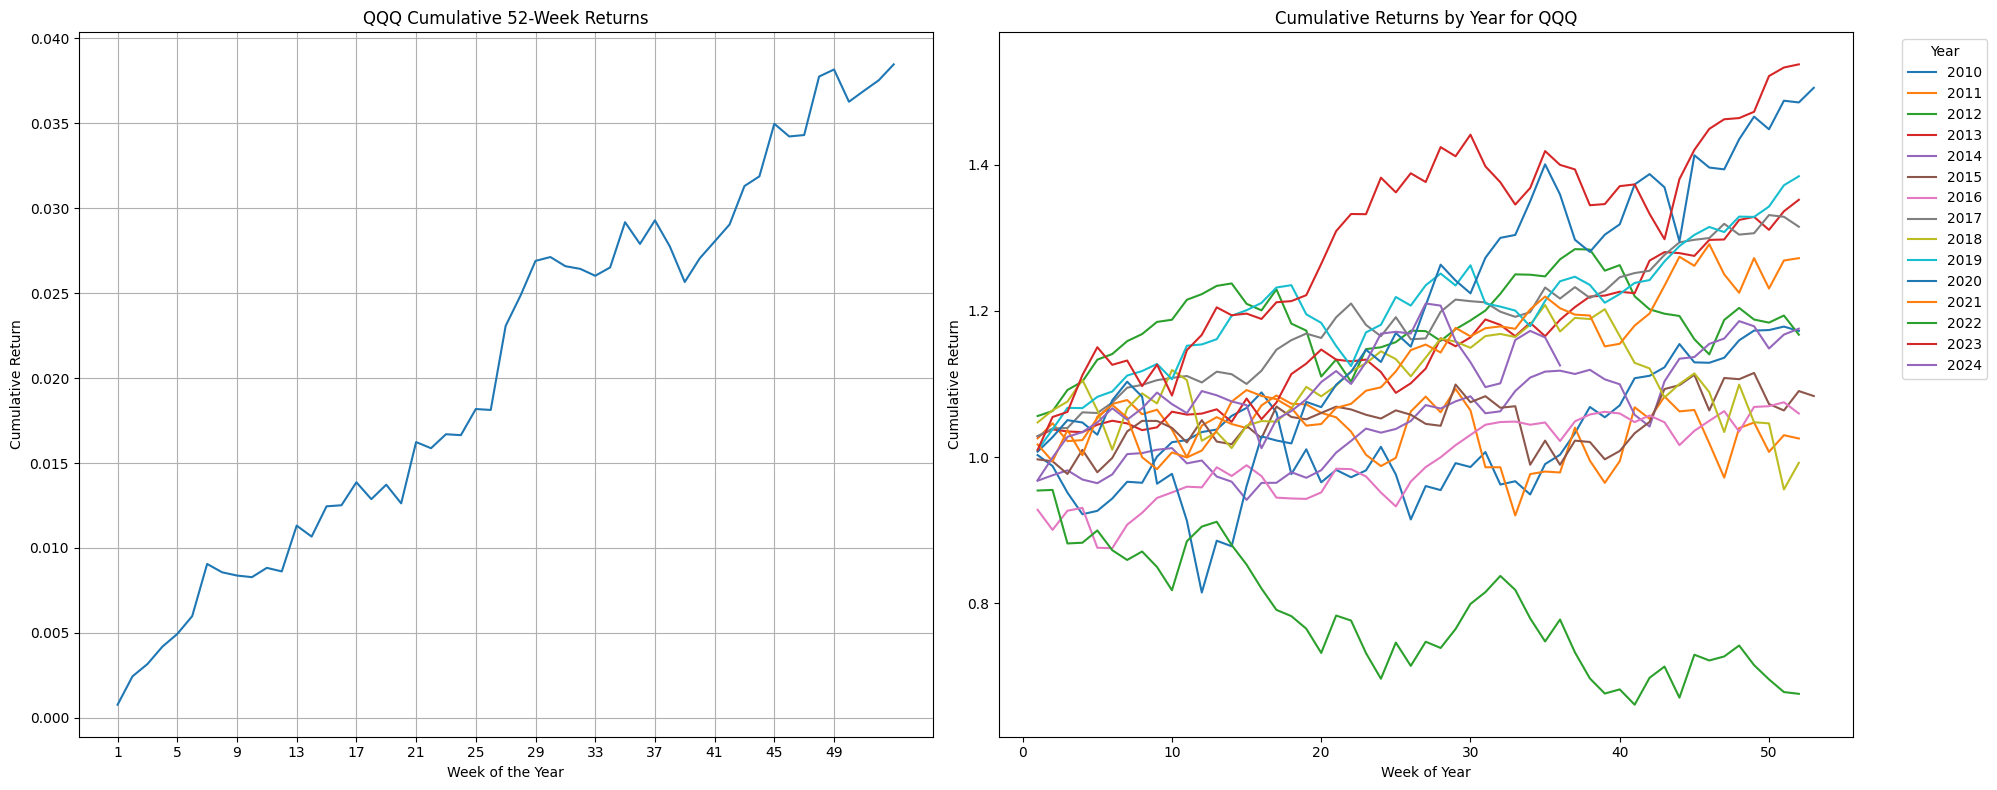

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


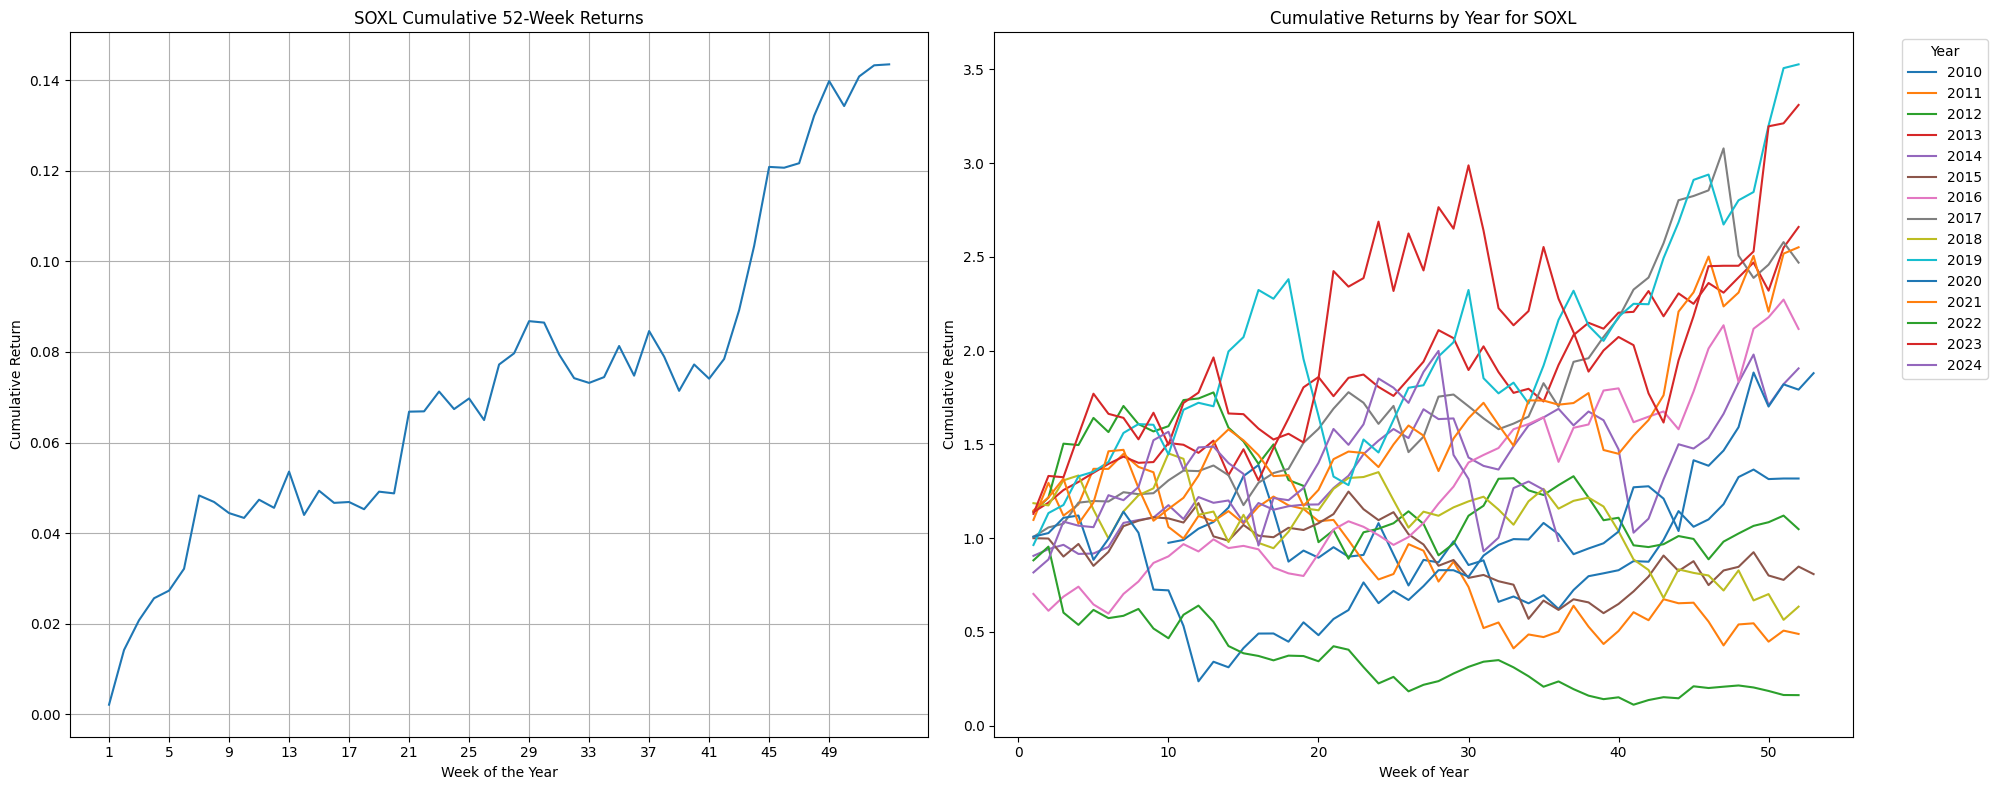

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


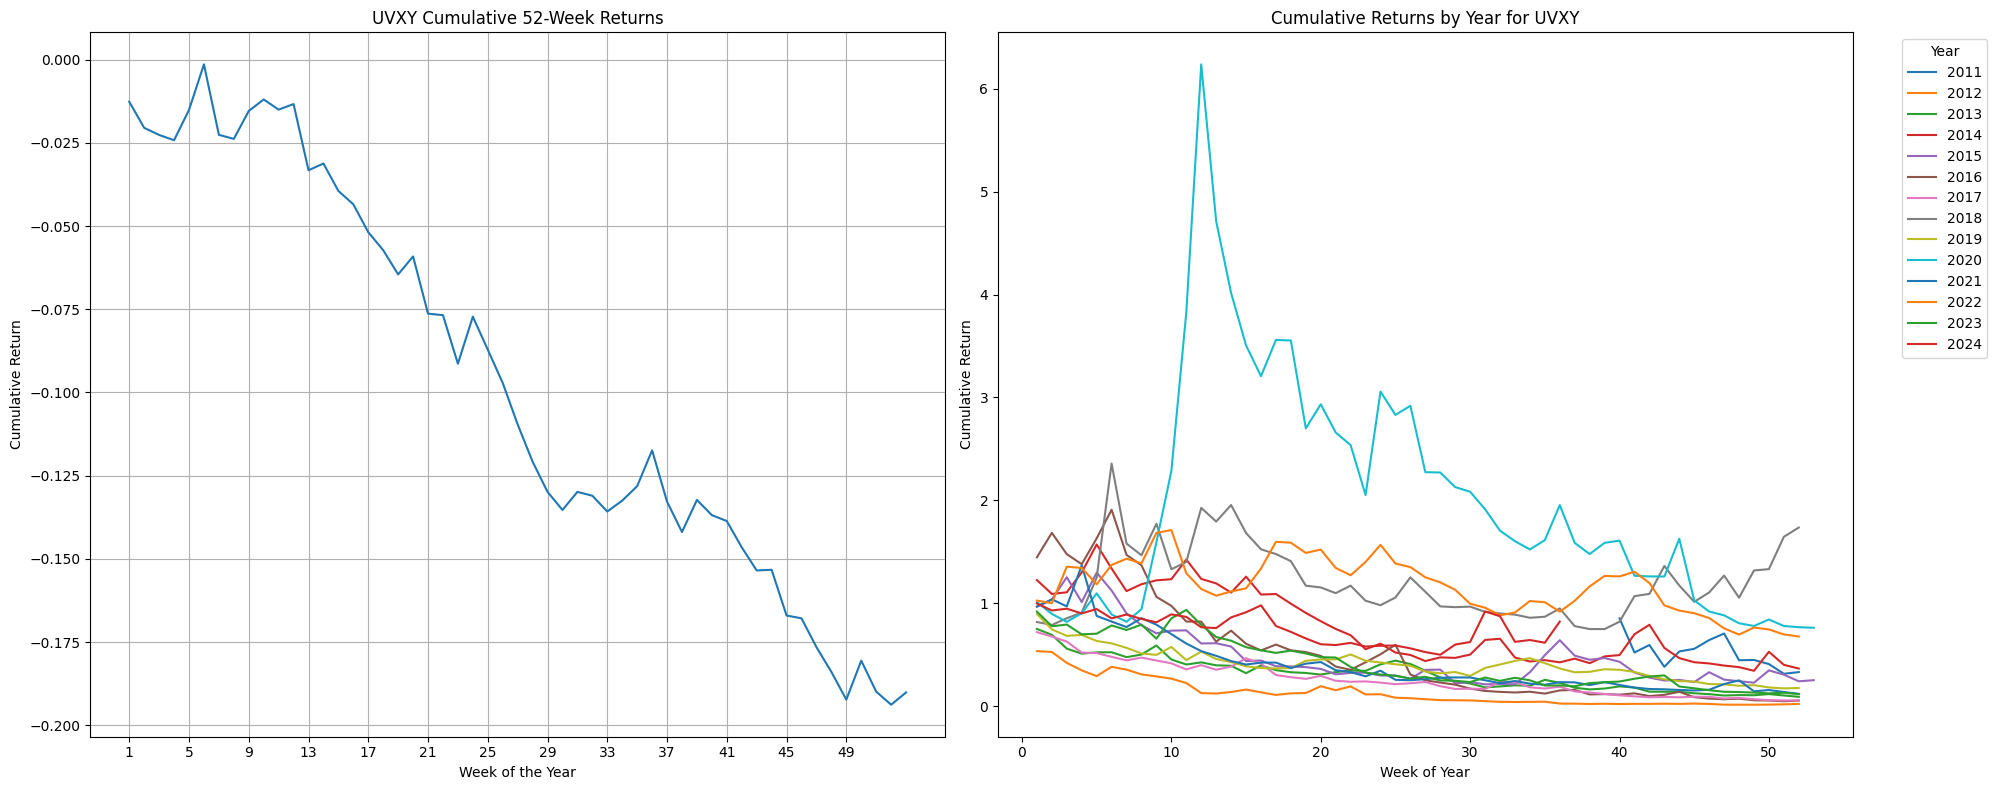

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


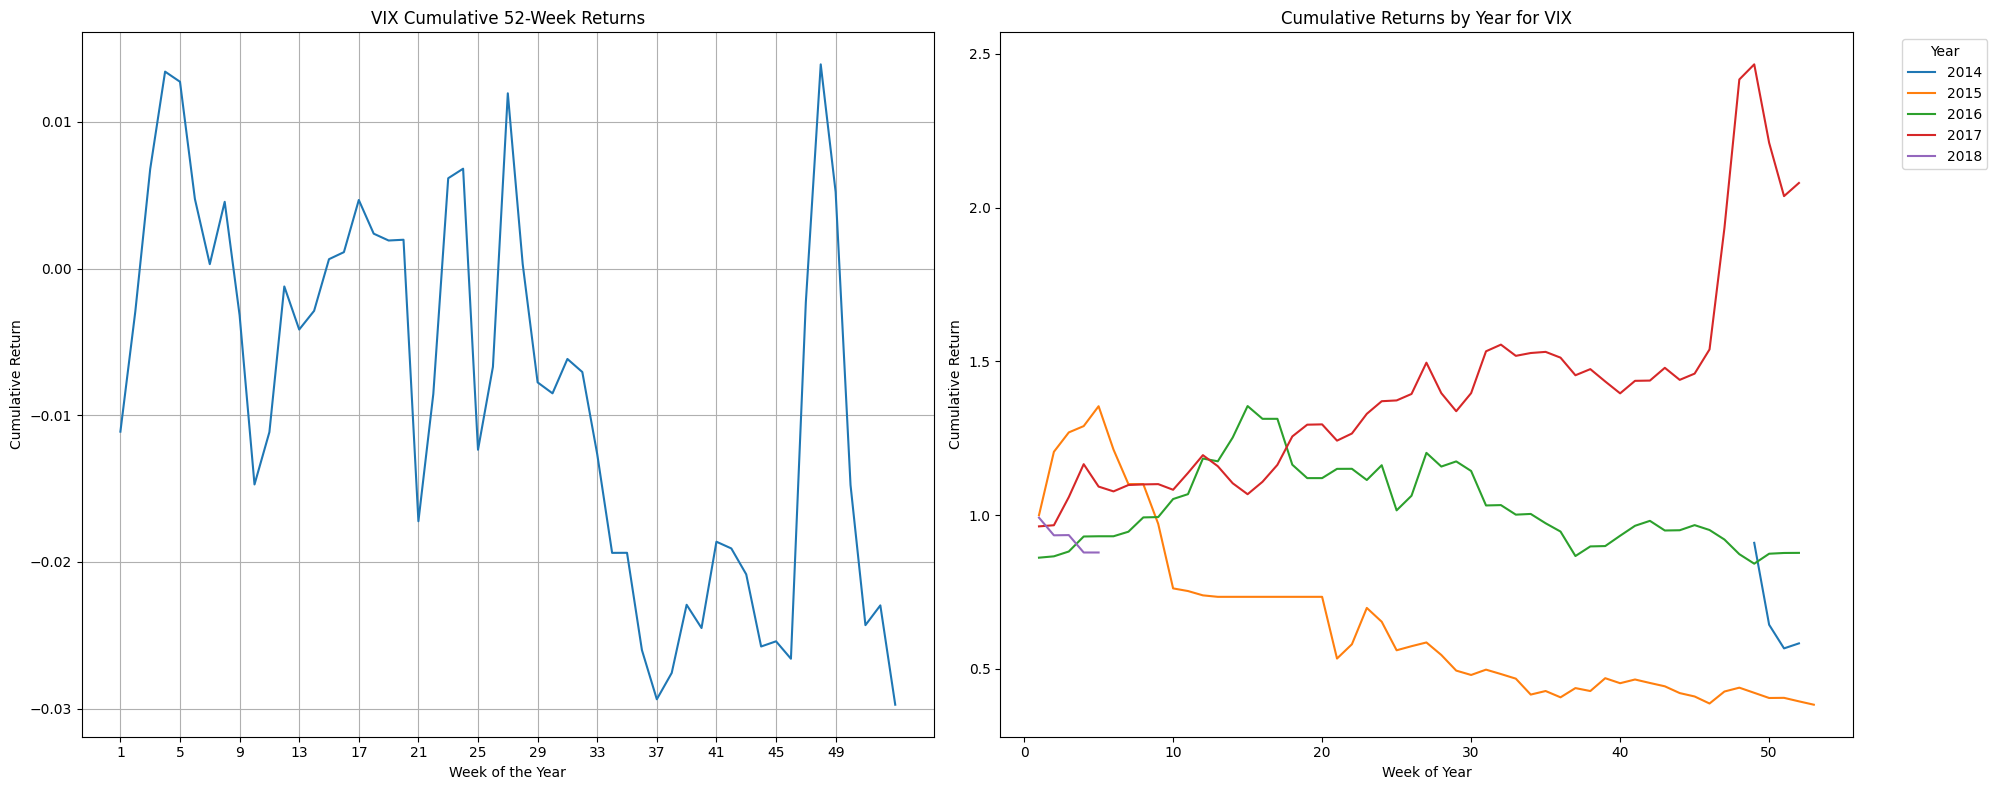

[*********************100%***********************]  5 of 5 completed


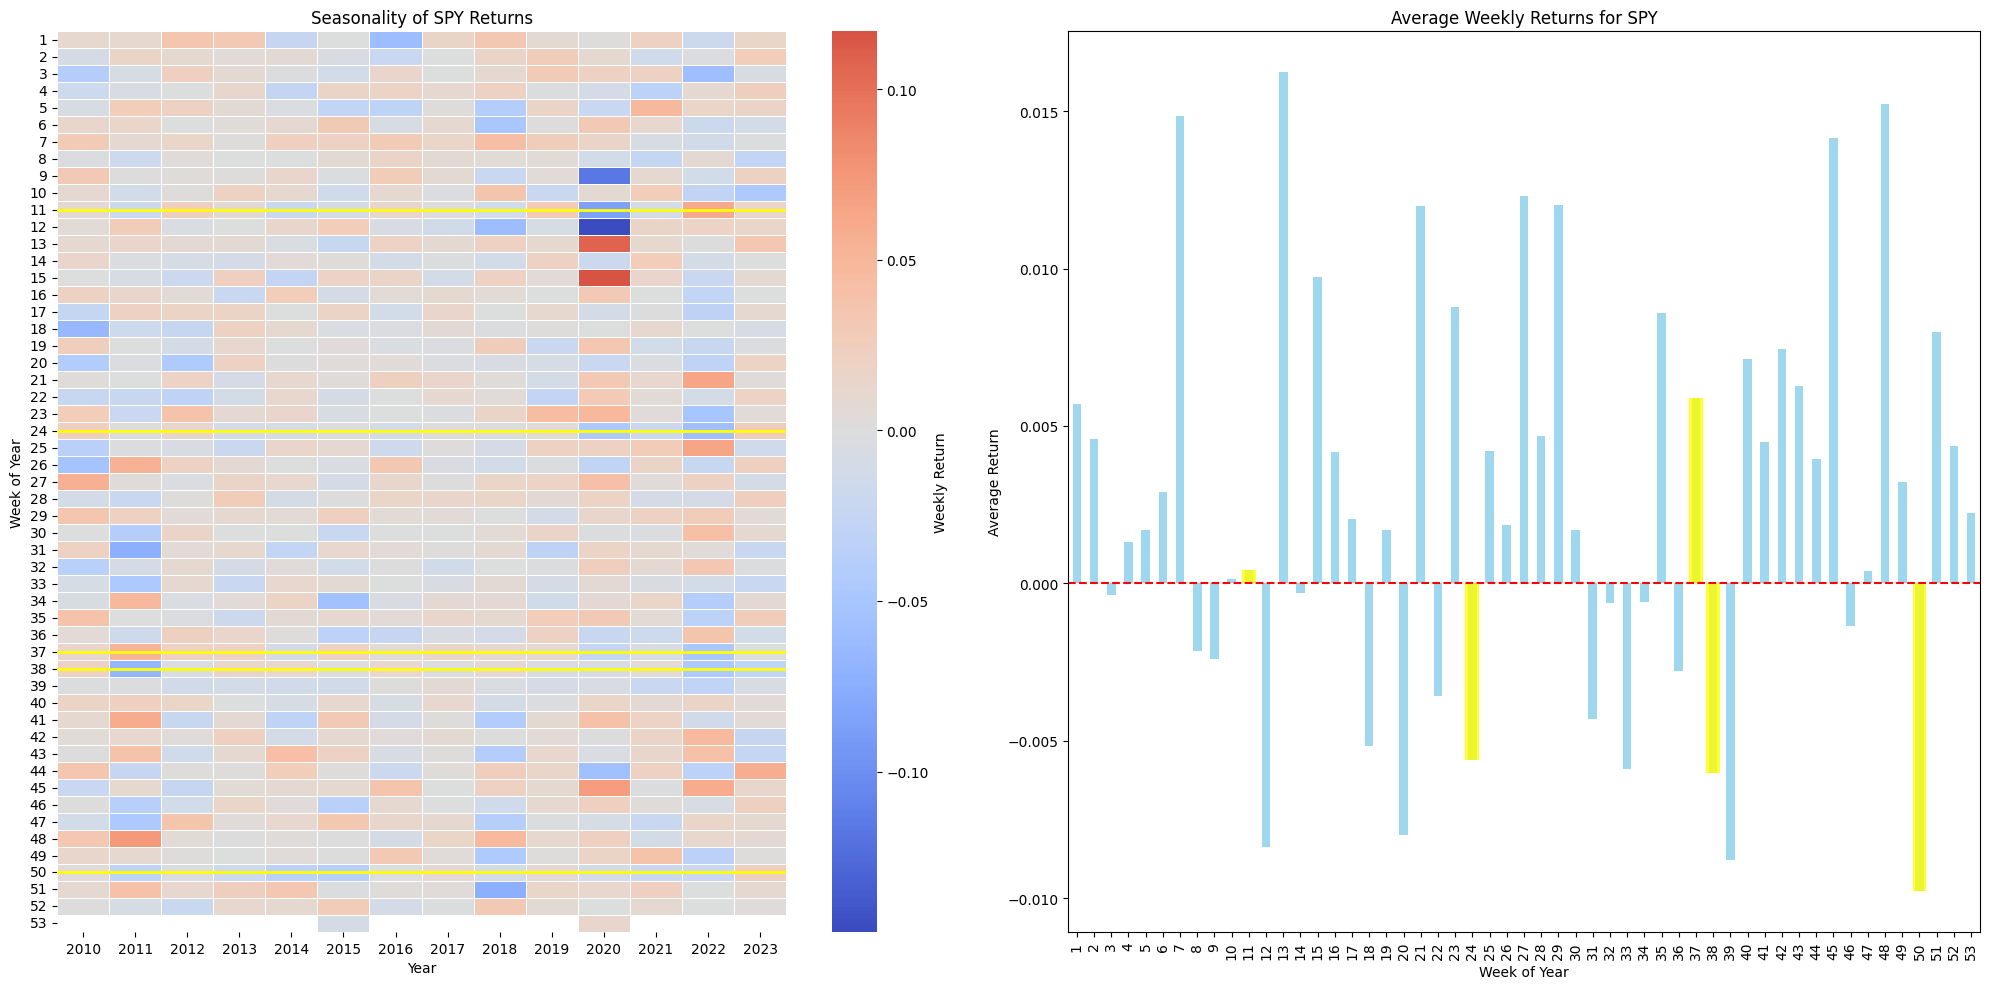

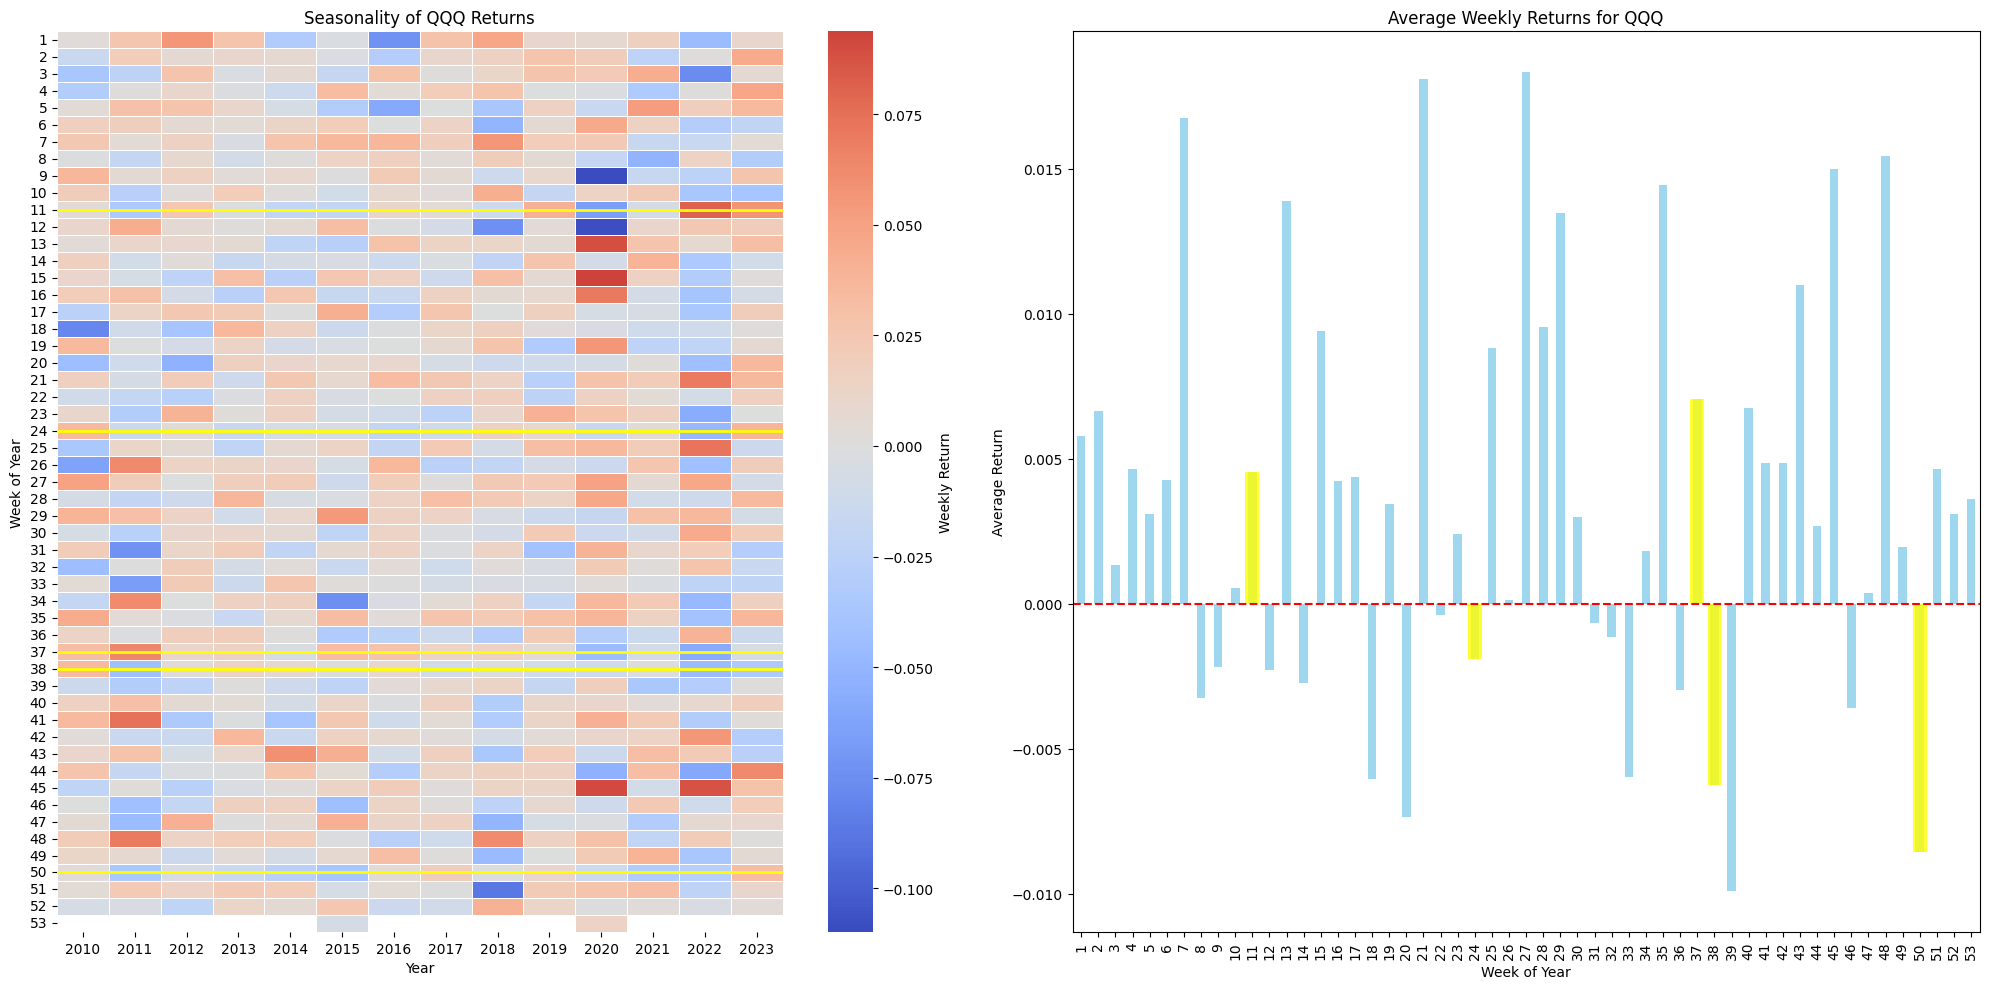

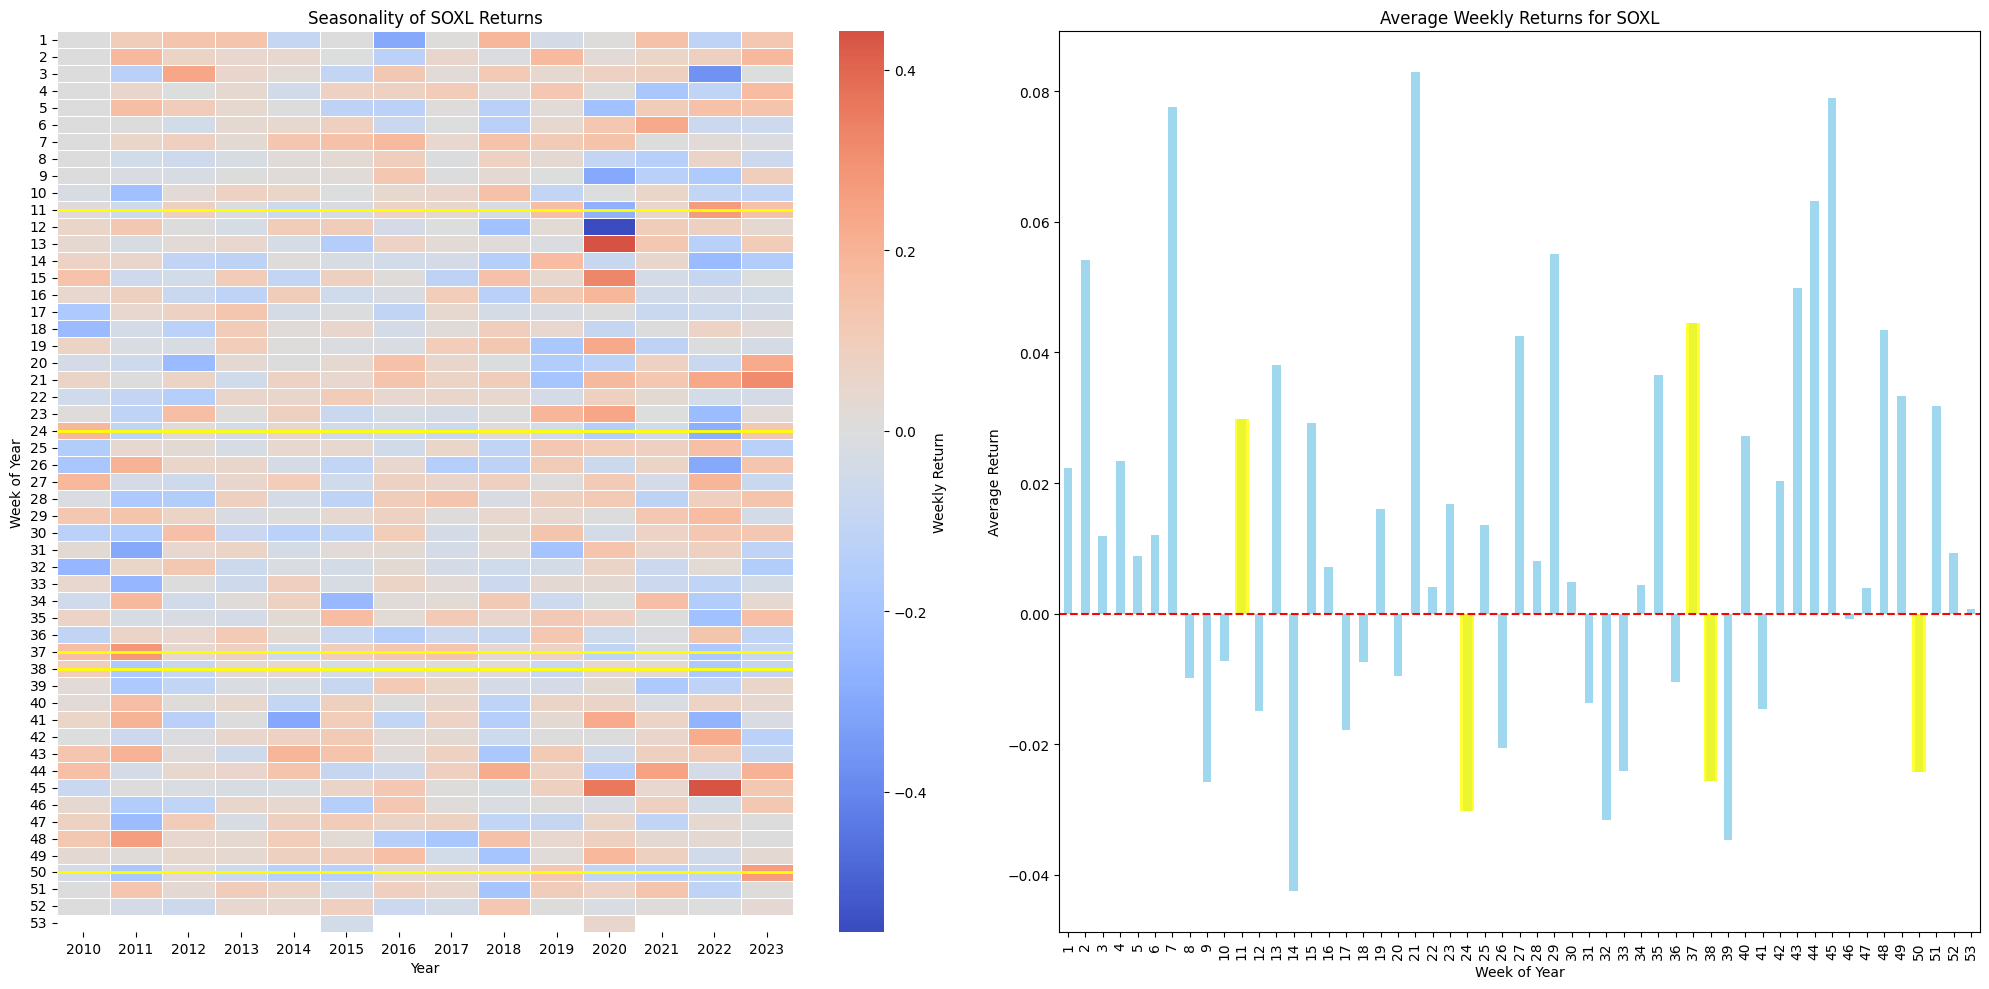

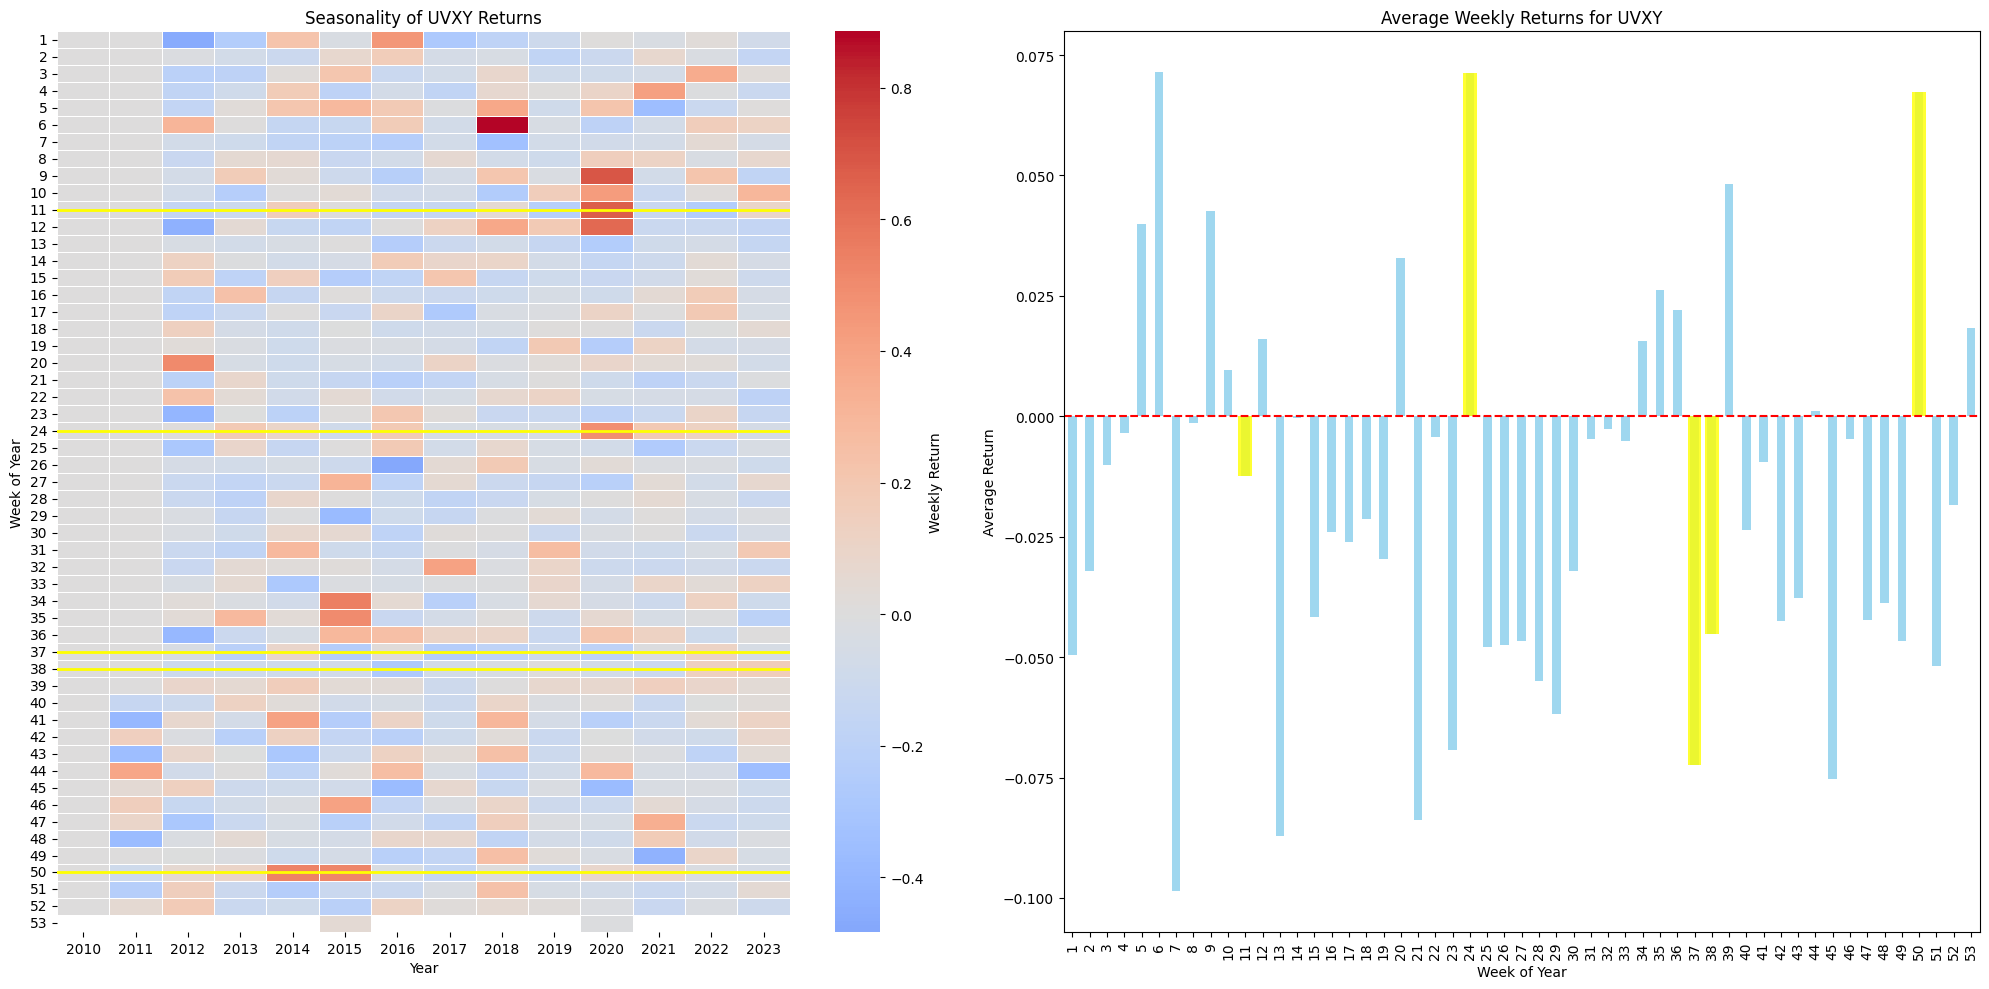

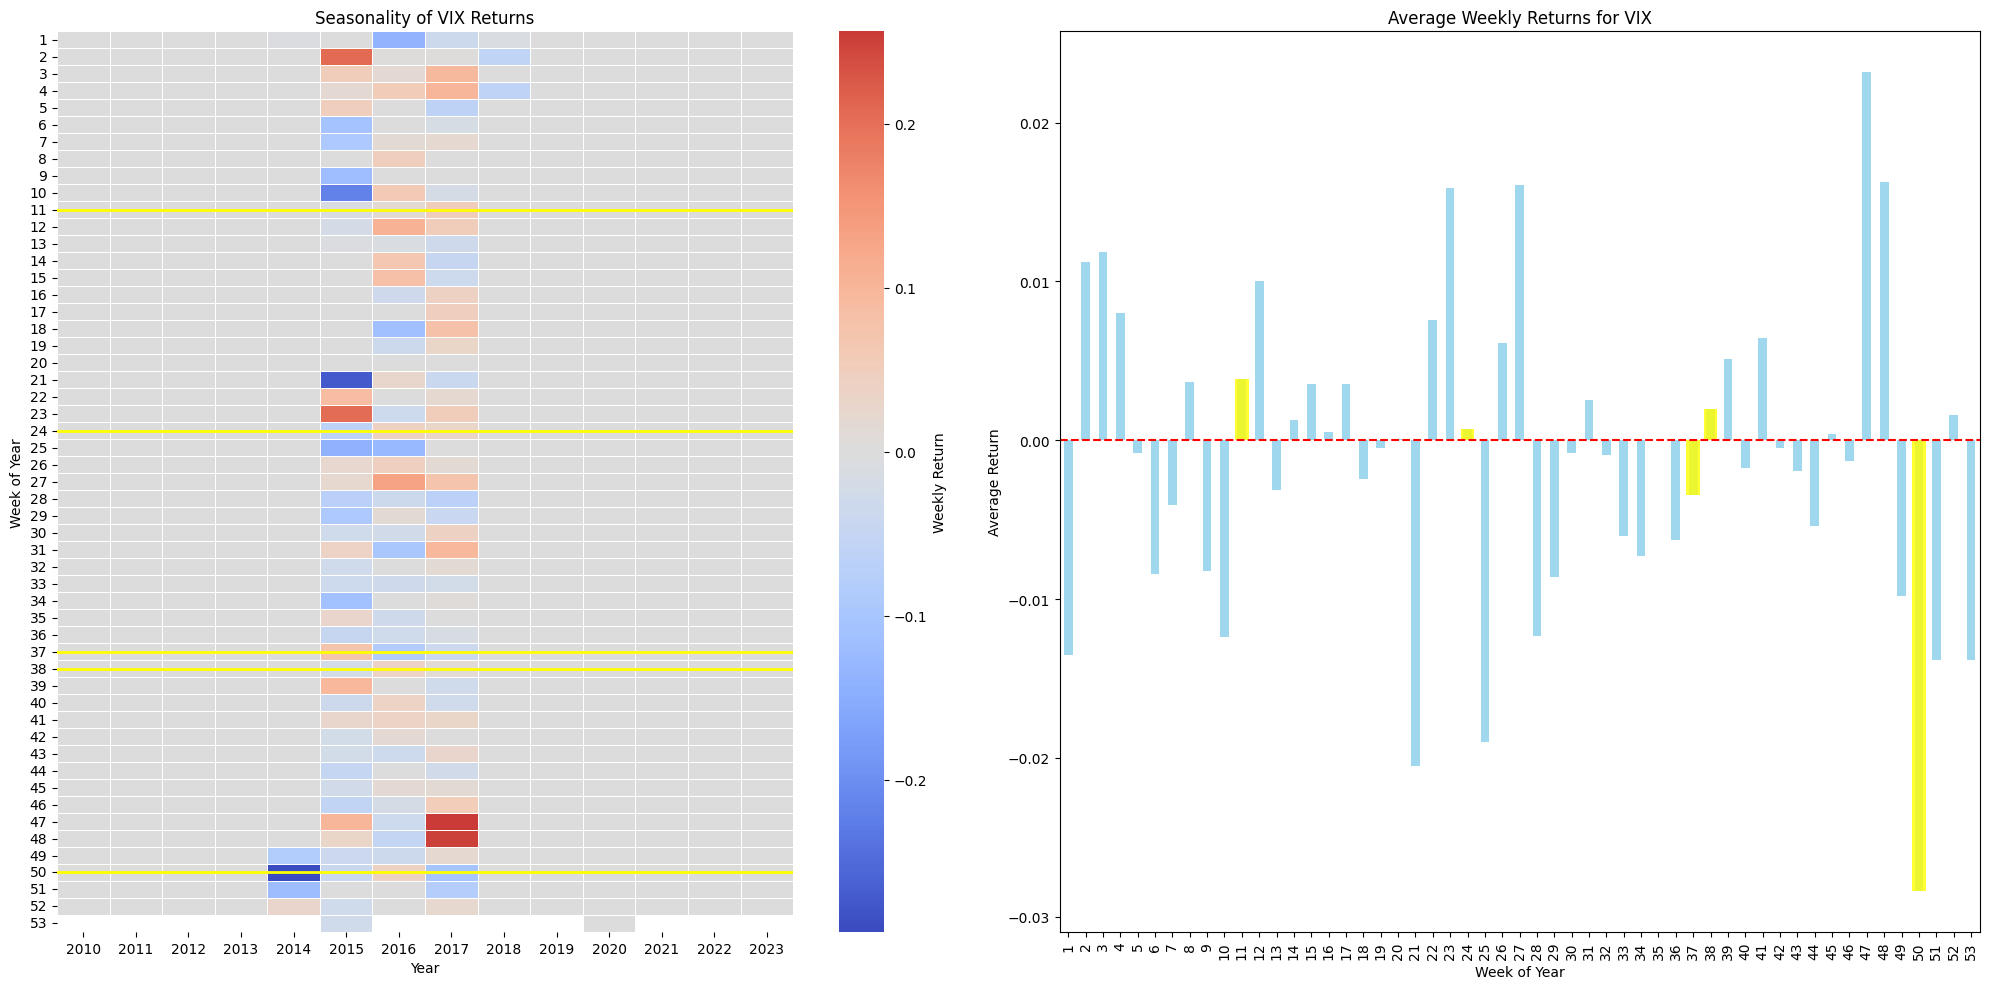

Saved SPY seasonality data to seasonality_data/SPY_seasonality.csv
Saved QQQ seasonality data to seasonality_data/QQQ_seasonality.csv
Saved SOXL seasonality data to seasonality_data/SOXL_seasonality.csv
Saved UVXY seasonality data to seasonality_data/UVXY_seasonality.csv
Saved VIX seasonality data to seasonality_data/VIX_seasonality.csv


In [7]:
class WeeklySeasonalityVisualizer:
    def __init__(self, tickers, start_date, end_date, triple_witching_weeks, odds_ratio=2, output_dir='seasonality_data'):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.triple_witching_weeks = triple_witching_weeks
        self.odds_ratio = odds_ratio
        self.output_dir = output_dir
        self.data = None

    def fetch_data(self):
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date, group_by='ticker')

    def visualize_weekly_seasonality(self):
        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Return'] = df['Adj Close'].pct_change()
            df['Week_Number'] = df.index.isocalendar().week
            df['Year'] = df.index.year
            df['Ticker'] = ticker

            weekly_data = df.groupby(['Year', 'Week_Number']).agg({
                'Return': 'sum',
                'Volume': 'mean'
            }).reset_index()
            weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

            pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            sns.heatmap(pivot_data, ax=ax1, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                        cbar_kws={'label': 'Weekly Return'})

            for week in self.triple_witching_weeks:
                ax1.axhline(y=week-0.5, color='yellow', linewidth=2)

            ax1.set_title(f'Seasonality of {ticker} Returns')
            ax1.set_ylabel('Week of Year')
            ax1.set_xlabel('Year')

            avg_weekly_returns = pivot_data.mean(axis=1)
            avg_weekly_returns.plot(ax=ax2, kind='bar', color='skyblue', alpha=0.8)
            ax2.set_title(f'Average Weekly Returns for {ticker}')
            ax2.set_xlabel('Week of Year')
            ax2.set_ylabel('Average Return')
            ax2.axhline(y=0, color='red', linestyle='--')

            for week in self.triple_witching_weeks:
                ax2.bar(week-1, avg_weekly_returns[week], color='yellow', alpha=0.8)

            plt.tight_layout()
            plt.show()

    def export_weekly_seasonality_data(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Return'] = df['Adj Close'].pct_change()
            df['Week_Number'] = df.index.isocalendar().week
            df['Year'] = df.index.year
            df['Ticker'] = ticker

            weekly_data = df.groupby(['Year', 'Week_Number']).agg({
                'Return': 'sum',
                'Volume': 'mean'
            }).reset_index()
            weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

            volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
            positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')

            kelly_ratio = (positive_returns['Positive_Returns'] * self.odds_ratio - 1) / self.odds_ratio
            weekly_data = weekly_data.merge(volatility, on='Week')
            weekly_data = weekly_data.merge(positive_returns, on='Week')
            weekly_data['Kelly_Ratio'] = kelly_ratio

            output_path = os.path.join(self.output_dir, f'{ticker}_seasonality.csv')
            weekly_data.to_csv(output_path, index=False)
            print(f'Saved {ticker} seasonality data to {output_path}')

class CumulativeReturnAnalyzer:
    def __init__(self, ticker, start_date='2008-01-01', end_date=None, plot=True):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        self.plot = plot

    def fetch_financial_data(self):
        return yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_cumulative_return(self, financial_df):
        weekly_returns = financial_df['Close'].pct_change().groupby(financial_df.index.isocalendar().week).mean()
        cumulative_returns = (1 + weekly_returns).cumprod() - 1
        return cumulative_returns

    def plot_cumulative_return(self, cumulative_returns):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        ax1.plot(cumulative_returns.index, cumulative_returns.values)
        ax1.set_title(f'{self.ticker} Cumulative 52-Week Returns')
        ax1.set_xlabel('Week of the Year')
        ax1.set_ylabel('Cumulative Return')
        ax1.set_xticks(range(1, 53, 4))
        ax1.grid(True)

        financial_df = self.fetch_financial_data()
        financial_df['Return'] = financial_df['Close'].pct_change()
        financial_df['Week_Number'] = financial_df.index.isocalendar().week
        financial_df['Year'] = financial_df.index.year

        weekly_data = financial_df.groupby(['Year', 'Week_Number'])['Return'].sum().reset_index()
        pivot_data = weekly_data.pivot(index="Week_Number", columns="Year", values="Return")
        yearly_cumulative_returns = (1 + pivot_data).cumprod()

        for year in yearly_cumulative_returns.columns:
            ax2.plot(yearly_cumulative_returns.index, yearly_cumulative_returns[year], label=year)
        
        ax2.set_title(f'Cumulative Returns by Year for {self.ticker}')
        ax2.set_xlabel('Week of Year')
        ax2.set_ylabel('Cumulative Return')
        ax2.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def process(self):
        financial_df = self.fetch_financial_data()
        cumulative_returns = self.calculate_cumulative_return(financial_df)
        if self.plot:
            self.plot_cumulative_return(cumulative_returns)
        return cumulative_returns


for ticker in tickers:
    # Fetch, calculate, and plot cumulative return for each ticker
    analyzer = CumulativeReturnAnalyzer(ticker=ticker, start_date='2010-01-01', plot=True)
    cumulative_returns = analyzer.process()    # print(cumulative_returns)


# Example usage:
triple_witching_weeks = [11, 24, 37, 38, 50]

visualizer = WeeklySeasonalityVisualizer(tickers, "2010-01-01", "2024-01-01", triple_witching_weeks)
visualizer.fetch_data()
visualizer.visualize_weekly_seasonality()
visualizer.export_weekly_seasonality_data()
